# Program - Plot domain-avg profiles in AM4

Content
- Read AM4 and SCM data
- Select time and region in AM4, and compute domain-averaged profiles
- Plot profiles using matplotlib

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import io, os, sys, types

import yhc_module as yhc

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

## Read AM4 and SCM data

In [34]:
#--- open AM4 data
datapath = "../data/"
#filename = "data-am4_20010725_8xdaily-temp.nc"
filename = "cm4p12_xanadu_am4p0_edmf_mynn.tt1-c96L33_am4p0_cm4amip_nudge2000_Jul2001.1x0m30d_432x2a.atmos_8xdaily_inst.lat_lon.nc.20010710.nc"

files_input = datapath+"/"+filename

#--- use xarray to open the files
data = xr.open_dataset(files_input)
data

<xarray.Dataset>
Dimensions:    (phalf: 34, lat: 180, bnds: 2, levhalf: 34, lon: 288, time: 8,
                pfull: 33)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * levhalf    (levhalf) float64 1.0 0.9959 0.9897 ... 0.008186 0.004 0.001
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * pfull      (pfull) float64 2.164 5.845 10.75 17.11 ... 985.4 992.8 997.9
  * phalf      (phalf) float64 1.0 4.0 8.186 13.79 ... 981.1 989.7 995.9 1e+03
  * time       (time) object 2001-07-10 03:00:00 ... 2001-07-11 00:00:00
Dimensions without coordinates: bnds
Data variables: (12/18)
    bk         (phalf) float32 ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    omega      (time, pfull, lat, lon) float32 ...
    pk         (phalf) float32 ...
    ps         (time, lat, lon) float32 ...
    ...         ...
    tdt_sw     (time, pfull, lat, lon) float32 ...
    temp       (time, pfull, lat, lon) float32 ...
    ucomp      (time, pfull, lat, lon) float32 ...
    vcomp      (time, pfull, lat, lon) float32 ...
    zg         (time, levhalf, lat, lon) float32 ...
    zsurf      (lat, lon) float32 ...
Attributes:
    filename:              20010701.atmos_8xdaily_inst.tile1.nc
    title:                 tt1-c96L33_am4p0_cm4amip_nudge2000_Jul2001
    associated_files:      area: 20010701.grid_spec.nc
    grid_type:             regular
    grid_tile:             N/A
    code_release_version:  19.1
    git_hash:              c97c1f6afab0df3545ee82c337d51accc4205bc3
    creationtime:          Sat Jul 23 17:41:41 2022
    hostname:              an005
    history:               Sat Jul 23 17:58:48 2022: ncks -F -d time,73,80 ./...
    NCO:                   "4.5.4"

In [35]:
#--- read SCM data

datapath = "../data/"

filename_scm_1xdiv = "SCM_am4_xanadu_edmf_mynn.v01_RF01-00cc-am4p0_aerT_clr_am4RAD_sw.1x0m5d_1x1a.atmos_edmf_mynn.nc"
filename_scm_2xdiv = "SCM_am4_xanadu_edmf_mynn.v01_RF01-00cc-am4p0_aerT_clr_am4RAD_sw_2Xdifv.1x0m5d_1x1a.atmos_edmf_mynn.nc"

files_scm_1xdiv = datapath+"/"+filename_scm_1xdiv
files_scm_2xdiv = datapath+"/"+filename_scm_2xdiv

#--- use xarray to open the files
scm_1xdiv = xr.open_dataset(files_scm_1xdiv)
scm_2xdiv = xr.open_dataset(files_scm_2xdiv)

## read data & print out variables for computing tendencies from vertical advection using SCM machinery

In [75]:
#--- set up
region = "DYCOMS"
#region = "Californian_Sc"
model = "AM4_L33_native"
time_step = "2001-07-10 09:00:00"

#--- get lat/lon of the region
lon_slice, lat_slice = yhc.get_region_latlon(region)

#--- read data
pt = data.temp.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
qq = data.sphum.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
omega = data.omega.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
tdt_dyn = data.tdt_dyn.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
tdt_nudge = data.tdt_nudge.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
tdt_lw = data.tdt_lw.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
tdt_sw = data.tdt_sw.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
qdt_dyn = data.qdt_dyn.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
qdt_nudge = data.qdt_nudge.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))
zg = data.zg.sel(time=time_step, lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))

#--- read pressure levels
ps_region = data.ps.sel(lat=lat_slice, lon=lon_slice)
pfull_region = yhc.mlevs_to_plevs(ps_region, model = model, plevs = "pfull").stack(loc=("lat","lon"))
phalf_region = yhc.mlevs_to_plevs(ps_region, model = model, plevs = "phalf").stack(loc=("lat","lon"))

phalf = phalf_region.sel(time=time_step)

nn = 0
#do_print = True
do_print = False


if (do_print):
    for nn in range(0,6):
        yhc.printv(phalf[0,:,nn],"phalf, n-th location = "+str(nn))
        yhc.printv(omega[0,:,nn],"omega, n-th location = "+str(nn))
        yhc.printv(pt[0,:,nn],"temp, n-th location = "+str(nn))
        yhc.printv(qq[0,:,nn],"qq, n-th location = "+str(nn))


pfull
phalf


## Output from SCM machinery

In [76]:
#*********************
#
# SCM experiment: xx2-RF01_A-vert_adv_offline_1x0m5d_1x1a.o269070393
#
#*********************

#--- create DataArray
tdt_vadv = tdt_dyn.copy()
qdt_vadv = qdt_dyn.copy()
tdt_adi  = tdt_dyn.copy()

tdt_vadv.attrs['long_name']='tdt_vadv'
qdt_vadv.attrs['long_name']='qdt_vadv'
tdt_adi.attrs['long_name']='tdt_adi'

#--- tdt & qdt vertical advection for each grid point
nn=0
tdt_vadv[0,:,nn] = [0.1657E-04  ,  0.7775E-05  ,  0.5102E-05  ,  0.9575E-05  ,  0.1861E-04  ,  0.3166E-04  ,  0.3315E-04  ,  0.1702E-04  ,  0.4020E-04  ,  0.1310E-03  ,  0.8217E-04  ,  0.9168E-04  ,  0.1919E-04  , -0.3824E-04  , -0.2704E-04  ,  0.8152E-05  ,  0.2970E-04  ,  0.3098E-04  ,  0.2543E-04  ,  0.3364E-04  ,  0.3599E-04  ,  0.4339E-04  ,  0.2430E-04  ,  0.5833E-04  ,  0.7494E-04  ,  0.2805E-03  ,  0.5484E-04  , -0.2356E-04  , -0.8633E-06  , -0.6583E-06  , -0.5799E-06  , -0.5453E-06  , -0.1214E-05]
tdt_adi[0,:,nn]  = [0.1657E-04  ,  0.4702E-05  ,  0.4188E-05  ,  0.8084E-05  ,  0.1554E-04  ,  0.2607E-04  ,  0.2738E-04  ,  0.1071E-04  ,  0.3511E-04  ,  0.1305E-03  ,  0.1996E-03  ,  0.1465E-03  ,  0.2366E-04  , -0.6894E-04  , -0.5833E-04  ,  0.2509E-04  ,  0.7581E-04  ,  0.8725E-04  ,  0.8782E-04  ,  0.8297E-04  ,  0.8904E-04  ,  0.9452E-04  ,  0.8804E-04  ,  0.8072E-04  ,  0.7529E-04  ,  0.6503E-04  ,  0.5085E-04  ,  0.3630E-04  ,  0.2456E-04  ,  0.1549E-04  ,  0.8414E-05  ,  0.3137E-05  , -0.4967E-06]
qdt_vadv[0,:,nn] = [0.0000E+00  , -0.9625E-14  , -0.2569E-14  , -0.4082E-16  ,  0.2215E-13  ,  0.9252E-13  ,  0.1487E-12  ,  0.4039E-14  , -0.1027E-11  , -0.9454E-14  ,  0.6606E-12  , -0.3181E-10  , -0.8473E-11  ,  0.5065E-09  ,  0.1156E-08  , -0.8141E-09  , -0.3794E-08  , -0.1564E-08  , -0.3752E-09  , -0.2556E-07  , -0.1366E-07  , -0.9069E-09  ,  0.3505E-08  , -0.1513E-08  ,  0.5099E-07  , -0.1095E-06  , -0.4832E-07  , -0.4758E-08  , -0.1329E-08  , -0.8643E-09  , -0.5333E-09  , -0.5491E-09  , -0.2494E-09]

nn=1
tdt_vadv[0,:,nn] = [-0.1398E-04  , -0.1290E-04  , -0.4588E-05  ,  0.2383E-05  ,  0.1310E-04  ,  0.1954E-04  ,  0.3322E-04  ,  0.1645E-04  ,  0.2910E-04  ,  0.1235E-03  ,  0.6957E-04  ,  0.7762E-04  ,  0.3180E-04  , -0.8965E-05  , -0.1196E-04  , -0.1039E-04  ,  0.1875E-04  ,  0.3346E-04  ,  0.2792E-04  ,  0.3386E-04  ,  0.3926E-04  ,  0.4372E-04  ,  0.5912E-04  ,  0.2437E-04  ,  0.6164E-04  ,  0.3443E-03  ,  0.9255E-04  , -0.1376E-04  , -0.1412E-05  , -0.8519E-06  , -0.6939E-06  , -0.5905E-06  , -0.1779E-05]
tdt_adi[0,:,nn]  = [-0.1129E-04  , -0.1058E-04  , -0.4215E-05  ,  0.1745E-05  ,  0.1119E-04  ,  0.1538E-04  ,  0.2784E-04  ,  0.1118E-04  ,  0.2205E-04  ,  0.1225E-03  ,  0.1838E-03  ,  0.1405E-03  ,  0.4852E-04  , -0.1093E-04  , -0.2493E-04  , -0.3179E-05  ,  0.5930E-04  ,  0.9186E-04  ,  0.8119E-04  ,  0.8083E-04  ,  0.9834E-04  ,  0.1141E-03  ,  0.1132E-03  ,  0.1007E-03  ,  0.8766E-04  ,  0.7411E-04  ,  0.5813E-04  ,  0.4078E-04  ,  0.2662E-04  ,  0.1614E-04  ,  0.8218E-05  ,  0.2404E-05  , -0.1543E-05]
qdt_vadv[0,:,nn] = [0.4473E-14  ,  0.1510E-13  , -0.6849E-17  ,  0.1343E-14  ,  0.1231E-13  ,  0.8094E-13  ,  0.1256E-12  ,  0.5144E-14  , -0.7369E-12  ,  0.1211E-11  , -0.4721E-11  , -0.1154E-10  , -0.5718E-10  ,  0.1150E-09  ,  0.3980E-09  , -0.4321E-09  , -0.2875E-08  , -0.1909E-08  , -0.1595E-08  , -0.2736E-07  , -0.2006E-07  , -0.3063E-08  ,  0.5934E-08  ,  0.7660E-09  ,  0.4868E-07  ,  0.9406E-08  , -0.1701E-06  , -0.1255E-07  , -0.2782E-08  , -0.1136E-08  , -0.6646E-09  , -0.4593E-09  , -0.8013E-10]

nn=2
tdt_vadv[0,:,nn] = [-0.5679E-04  , -0.4999E-04  , -0.3374E-04  , -0.2620E-04  , -0.1520E-04  , -0.1074E-04  ,  0.1240E-04  ,  0.1752E-05  ,  0.3825E-05  ,  0.7874E-04  ,  0.4273E-04  ,  0.6001E-04  ,  0.4801E-04  ,  0.2509E-04  , -0.1505E-05  , -0.3445E-04  ,  0.7452E-06  ,  0.3240E-04  ,  0.3937E-04  ,  0.4188E-04  ,  0.3809E-04  ,  0.2857E-04  ,  0.5423E-04  ,  0.3919E-04  ,  0.3451E-04  ,  0.2276E-03  ,  0.1284E-03  ,  0.3685E-04  , -0.1642E-04  , -0.9235E-06  , -0.6339E-06  ,  0.2744E-05  , -0.1002E-04]
tdt_adi[0,:,nn]  = [-0.4639E-04  , -0.3970E-04  , -0.2939E-04  , -0.2317E-04  , -0.1288E-04  , -0.9990E-05  ,  0.1129E-04  ,  0.9770E-06  , -0.5023E-06  ,  0.7797E-04  ,  0.1284E-03  ,  0.1193E-03  ,  0.7939E-04  ,  0.4963E-04  , -0.8686E-05  , -0.5431E-04  ,  0.1850E-04  ,  0.8818E-04  ,  0.9241E-04  ,  0.9083E-04  ,  0.9527E-04  ,  0.1004E-03  ,  0.1000E-03  ,  0.8960E-04  ,  0.7515E-04  ,  0.6324E-04  ,  0.5146E-04  ,  0.3639E-04  ,  0.2143E-04  ,  0.9512E-05  ,  0.6557E-06  , -0.5737E-05  , -0.1002E-04]
qdt_vadv[0,:,nn] = [0.1653E-13  ,  0.7208E-13  , -0.5815E-15  , -0.7338E-14  , -0.1504E-13  , -0.5041E-14  ,  0.1578E-13  ,  0.1179E-14  , -0.6174E-14  ,  0.4649E-12  , -0.2473E-11  , -0.3087E-11  , -0.9770E-10  , -0.1535E-09  , -0.9250E-11  ,  0.3959E-09  , -0.1724E-08  , -0.4444E-08  , -0.1372E-07  , -0.2261E-07  , -0.9992E-08  , -0.3293E-08  , -0.5036E-09  ,  0.1361E-07  ,  0.9530E-08  ,  0.4741E-07  , -0.1383E-06  , -0.2885E-07  , -0.3732E-08  , -0.8167E-09  , -0.1385E-09  ,  0.2017E-08  ,  0.0000E+00]

nn=3
tdt_vadv[0,:,nn] = [0.1423E-04  , -0.3881E-05  ,  0.2717E-05  ,  0.8219E-05  ,  0.1025E-04  ,  0.2763E-04  ,  0.4521E-04  ,  0.3051E-04  ,  0.2405E-04  ,  0.1104E-03  ,  0.7941E-04  ,  0.8497E-04  ,  0.2334E-04  , -0.2095E-04  , -0.1998E-04  ,  0.1498E-04  ,  0.1652E-04  ,  0.4179E-05  ,  0.1103E-04  ,  0.2238E-04  ,  0.2650E-04  ,  0.2787E-04  ,  0.1240E-04  ,  0.5453E-04  ,  0.2075E-03  ,  0.1554E-03  ,  0.4786E-04  , -0.2174E-04  , -0.9223E-06  , -0.5890E-06  , -0.4569E-06  , -0.3943E-06  , -0.9400E-06]
tdt_adi[0,:,nn]  = [0.1423E-04  , -0.4139E-05  ,  0.2156E-05  ,  0.7223E-05  ,  0.8015E-05  ,  0.2216E-04  ,  0.3755E-04  ,  0.2324E-04  ,  0.2190E-04  ,  0.1103E-03  ,  0.1827E-03  ,  0.1252E-03  ,  0.2859E-04  , -0.3648E-04  , -0.3439E-04  ,  0.3071E-04  ,  0.3959E-04  ,  0.2598E-04  ,  0.4259E-04  ,  0.5670E-04  ,  0.6682E-04  ,  0.6586E-04  ,  0.6398E-04  ,  0.7108E-04  ,  0.7591E-04  ,  0.6554E-04  ,  0.4714E-04  ,  0.3059E-04  ,  0.1941E-04  ,  0.1171E-04  ,  0.6137E-05  ,  0.2156E-05  , -0.5012E-06]
qdt_vadv[0,:,nn] = [0.4308E-28  , -0.4604E-15  , -0.3642E-14  , -0.9914E-15  ,  0.1266E-13  ,  0.1161E-12  ,  0.1756E-12  ,  0.4310E-14  , -0.8240E-12  ,  0.2446E-12  ,  0.2270E-12  , -0.4062E-10  , -0.2294E-10  ,  0.2856E-09  ,  0.4774E-09  , -0.4770E-09  , -0.1815E-08  , -0.1047E-08  , -0.2337E-10  , -0.1832E-07  , -0.4597E-08  ,  0.1389E-07  ,  0.5169E-08  ,  0.3989E-08  ,  0.1477E-07  , -0.1364E-06  , -0.3757E-07  , -0.4016E-08  , -0.1071E-08  , -0.6786E-09  , -0.4079E-09  , -0.3957E-09  , -0.1617E-09]

nn=4
tdt_vadv[0,:,nn] = [-0.2564E-04  , -0.3842E-04  , -0.2355E-04  , -0.3901E-05  ,  0.6151E-05  ,  0.6505E-05  ,  0.3277E-04  ,  0.3030E-04  ,  0.8811E-05  ,  0.1012E-03  ,  0.7622E-04  ,  0.7874E-04  ,  0.3466E-04  , -0.9680E-05  , -0.1671E-04  ,  0.4173E-05  ,  0.9706E-05  ,  0.7481E-06  ,  0.7253E-05  ,  0.2629E-04  ,  0.3675E-04  ,  0.3654E-04  ,  0.3376E-04  ,  0.3441E-04  ,  0.6970E-04  ,  0.3359E-03  ,  0.7998E-04  , -0.1944E-04  , -0.1164E-05  , -0.8722E-06  , -0.6528E-06  , -0.2062E-06  , -0.2705E-05]
tdt_adi[0,:,nn]  = [-0.1877E-04  , -0.3104E-04  , -0.2124E-04  , -0.3490E-05  ,  0.5524E-05  ,  0.3965E-05  ,  0.2712E-04  ,  0.2459E-04  ,  0.5499E-05  ,  0.1008E-03  ,  0.1826E-03  ,  0.1309E-03  ,  0.4584E-04  , -0.1485E-04  , -0.3211E-04  ,  0.4722E-05  ,  0.2157E-04  ,  0.1606E-04  ,  0.3131E-04  ,  0.6136E-04  ,  0.8555E-04  ,  0.8740E-04  ,  0.7935E-04  ,  0.7582E-04  ,  0.7779E-04  ,  0.7311E-04  ,  0.5880E-04  ,  0.4058E-04  ,  0.2536E-04  ,  0.1450E-04  ,  0.6661E-05  ,  0.1054E-05  , -0.2705E-05]
qdt_vadv[0,:,nn] = [0.8469E-14  ,  0.2564E-13  ,  0.2243E-13  ,  0.1450E-27  ,  0.3168E-14  ,  0.6026E-13  ,  0.1045E-12  ,  0.3787E-14  , -0.5173E-12  ,  0.1071E-11  , -0.4671E-11  , -0.2045E-10  , -0.5723E-10  ,  0.1768E-09  ,  0.5431E-09  , -0.1105E-09  , -0.6032E-09  , -0.9777E-10  ,  0.1548E-09  , -0.1905E-07  , -0.1707E-07  , -0.2766E-08  ,  0.2131E-07  ,  0.8039E-08  ,  0.2375E-07  , -0.5517E-07  , -0.1268E-06  , -0.1105E-07  , -0.2654E-08  , -0.1005E-08  , -0.5430E-09  , -0.1096E-09  ,  0.0000E+00]

nn=5
tdt_vadv[0,:,nn] = [-0.4060E-04  , -0.5540E-04  , -0.4666E-04  , -0.2607E-04  , -0.1128E-04  , -0.1780E-04  ,  0.1176E-04  ,  0.1594E-04  , -0.1515E-04  ,  0.7115E-04  ,  0.5848E-04  ,  0.6321E-04  ,  0.4302E-04  ,  0.5583E-05  , -0.1811E-04  , -0.2801E-04  , -0.2280E-05  ,  0.1646E-04  ,  0.2257E-04  ,  0.3146E-04  ,  0.3282E-04  ,  0.2576E-04  ,  0.3444E-04  ,  0.1900E-04  ,  0.3304E-04  ,  0.2468E-03  ,  0.1003E-03  ,  0.4133E-04  , -0.1913E-04  , -0.9774E-06  , -0.7604E-06  ,  0.2769E-05  , -0.1071E-04]
tdt_adi[0,:,nn]  = [-0.3063E-04  , -0.4363E-04  , -0.4138E-04  , -0.2302E-04  , -0.8805E-05  , -0.1638E-04  ,  0.9913E-05  ,  0.1474E-04  , -0.1690E-04  ,  0.7078E-04  ,  0.1483E-03  ,  0.1152E-03  ,  0.5953E-04  ,  0.3384E-05  , -0.5756E-04  , -0.7011E-04  , -0.8164E-05  ,  0.4430E-04  ,  0.5918E-04  ,  0.6991E-04  ,  0.7473E-04  ,  0.7132E-04  ,  0.6460E-04  ,  0.5774E-04  ,  0.5658E-04  ,  0.5766E-04  ,  0.5340E-04  ,  0.4125E-04  ,  0.2573E-04  ,  0.1224E-04  ,  0.1867E-05  , -0.5665E-05  , -0.1071E-04]
qdt_vadv[0,:,nn] = [0.1154E-13  ,  0.4484E-13  ,  0.4195E-13  , -0.8531E-15  , -0.1054E-13  , -0.2400E-13  ,  0.6479E-14  ,  0.1847E-12  ,  0.0000E+00  ,  0.4383E-12  , -0.1979E-11  , -0.7278E-11  , -0.7991E-10  ,  0.2113E-09  ,  0.1004E-08  ,  0.1131E-08  ,  0.2539E-09  , -0.5643E-09  , -0.1203E-08  , -0.1842E-07  , -0.1762E-07  , -0.5208E-08  ,  0.1002E-07  ,  0.1111E-07  ,  0.1459E-07  ,  0.1008E-07  , -0.1414E-06  , -0.3014E-07  , -0.4627E-08  , -0.1252E-08  , -0.2536E-09  ,  0.1964E-08  ,  0.0000E+00]


In [77]:
#*********************
#
# SCM experiment: 
#
#.  tdt_vadv uses different options in subroutine vert_advection
#*********************

scheme2 = np.arange(0,6)
pfull2  = np.arange(0,33)
loc2    = np.arange(0,6)

dT_vadv_schemes = xr.DataArray(dims=['scheme', 'pfull', 'loc'], coords=[scheme2, pfull2, loc2])
dqv_vadv_schemes = dT_vadv_schemes.copy()

nn=0
 ### vadvec_scheme:            1
dT_vadv_schemes[0,:,nn]   = [    0.1625E-05  ,  0.1680E-05  ,  0.9714E-06  ,  0.1550E-05  ,  0.3277E-05  ,  0.5729E-05  ,  0.5580E-05  ,  0.5662E-05  ,  0.4542E-05  , -0.4093E-04  , -0.8258E-04  , -0.5364E-04  , -0.4096E-05  ,  0.3229E-04  ,  0.2910E-04  , -0.1554E-04  , -0.4572E-04  , -0.5654E-04  , -0.6051E-04  , -0.5160E-04  , -0.5209E-04  , -0.5358E-04  , -0.5348E-04  , -0.3476E-04  ,  0.8162E-04  ,  0.1094E-03  , -0.5127E-05  , -0.3619E-04  , -0.2600E-04  , -0.1675E-04  , -0.9476E-05  , -0.4093E-05  , -0.8849E-06  ]
dqv_vadv_schemes[0,:,nn]   = [   -0.3843E-14  , -0.6374E-14  , -0.2848E-14  ,  0.6106E-14  ,  0.2426E-13  ,  0.1314E-12  ,  0.1050E-12  , -0.5971E-12  , -0.5191E-12  ,  0.3718E-12  , -0.1171E-10  , -0.3293E-10  ,  0.2727E-10  ,  0.7708E-09  ,  0.9357E-09  , -0.8660E-09  , -0.3147E-08  , -0.2201E-08  , -0.5971E-08  , -0.1705E-07  , -0.1450E-07  , -0.1431E-08  ,  0.1106E-08  ,  0.2088E-07  ,  0.3348E-08  , -0.7097E-07  , -0.5962E-07  , -0.8382E-08  , -0.1727E-08  , -0.9420E-09  , -0.6259E-09  , -0.4460E-09  , -0.2253E-09  ]
 ### vadvec_scheme:            2
dT_vadv_schemes[1,:,nn]   = [    0.1625E-05  ,  0.1851E-05  ,  0.9298E-06  ,  0.1508E-05  ,  0.3152E-05  ,  0.5755E-05  ,  0.5675E-05  ,  0.6191E-05  ,  0.9995E-05  , -0.3752E-04  , -0.9187E-04  , -0.5170E-04  , -0.4962E-05  ,  0.3135E-04  ,  0.3072E-04  , -0.1723E-04  , -0.4588E-04  , -0.5581E-04  , -0.6232E-04  , -0.5023E-04  , -0.5156E-04  , -0.5313E-04  , -0.5577E-04  , -0.4818E-04  ,  0.1007E-03  ,  0.1292E-03  , -0.2158E-04  , -0.4229E-04  , -0.2573E-04  , -0.1636E-04  , -0.9139E-05  , -0.3745E-05  , -0.8849E-06  ]
dqv_vadv_schemes[1,:,nn]   = [   -0.3843E-14  , -0.6885E-14  , -0.4075E-14  ,  0.5714E-14  ,  0.1344E-13  ,  0.1420E-12  ,  0.1861E-12  , -0.6567E-12  , -0.9436E-12  ,  0.2653E-11  , -0.5264E-11  , -0.1824E-10  , -0.4022E-10  ,  0.6124E-09  ,  0.1091E-08  , -0.8318E-09  , -0.3465E-08  , -0.1448E-08  , -0.4999E-08  , -0.1948E-07  , -0.1603E-07  ,  0.9736E-09  , -0.1349E-08  ,  0.2753E-07  ,  0.1086E-07  , -0.8703E-07  , -0.6310E-07  , -0.1108E-08  , -0.8520E-09  , -0.8646E-09  , -0.5745E-09  , -0.5082E-09  , -0.2253E-09  ]
 ### vadvec_scheme:            3
dT_vadv_schemes[2,:,nn]   = [   -0.2891E-20  ,  0.3323E-05  ,  0.8521E-06  ,  0.1511E-05  ,  0.3027E-05  ,  0.5512E-05  ,  0.5927E-05  ,  0.5716E-05  ,  0.6075E-05  ,  0.3131E-18  , -0.1156E-03  , -0.6026E-04  , -0.1390E-05  ,  0.3186E-04  ,  0.3100E-04  , -0.1803E-04  , -0.4956E-04  , -0.5080E-04  , -0.6411E-04  , -0.5318E-04  , -0.4507E-04  , -0.6001E-04  , -0.4435E-04  , -0.3848E-04  , -0.3761E-18  ,  0.2188E-03  ,  0.0000E+00  , -0.5951E-04  , -0.2585E-04  , -0.1615E-04  , -0.9003E-05  , -0.3651E-05  , -0.7220E-06  ]
dqv_vadv_schemes[2,:,nn]   = [    0.0000E+00  , -0.8885E-14  , -0.3174E-14  , -0.1450E-27  ,  0.2536E-13  ,  0.7072E-13  ,  0.1689E-12  ,  0.0000E+00  , -0.1038E-11  ,  0.2332E-26  ,  0.6606E-12  , -0.3173E-10  , -0.2915E-10  ,  0.5263E-09  ,  0.1184E-08  , -0.8798E-09  , -0.3082E-08  , -0.2359E-08  , -0.2447E-09  , -0.2161E-07  , -0.1892E-07  ,  0.1079E-22  ,  0.3505E-08  , -0.1513E-08  ,  0.5099E-07  , -0.8723E-07  , -0.7772E-07  , -0.2007E-08  , -0.6441E-09  , -0.7860E-09  , -0.5872E-09  , -0.4211E-09  , -0.2712E-09  ]
 ### vadvec_scheme:            4
dT_vadv_schemes[3,:,nn]   = [   -0.2891E-20  ,  0.3074E-05  ,  0.9143E-06  ,  0.1491E-05  ,  0.3064E-05  ,  0.5592E-05  ,  0.5773E-05  ,  0.6313E-05  ,  0.5088E-05  ,  0.4788E-06  , -0.1174E-03  , -0.5478E-04  , -0.4468E-05  ,  0.3069E-04  ,  0.3129E-04  , -0.1694E-04  , -0.4611E-04  , -0.5627E-04  , -0.6239E-04  , -0.4933E-04  , -0.5306E-04  , -0.5113E-04  , -0.6373E-04  , -0.2238E-04  , -0.3577E-06  ,  0.2155E-03  ,  0.3990E-05  , -0.5986E-04  , -0.2542E-04  , -0.1614E-04  , -0.8994E-05  , -0.3682E-05  , -0.7175E-06  ]
dqv_vadv_schemes[3,:,nn]   = [    0.0000E+00  , -0.9625E-14  , -0.2569E-14  , -0.4082E-16  ,  0.2215E-13  ,  0.9252E-13  ,  0.1487E-12  ,  0.4039E-14  , -0.1027E-11  , -0.9454E-14  ,  0.6606E-12  , -0.3181E-10  , -0.8473E-11  ,  0.5065E-09  ,  0.1156E-08  , -0.8141E-09  , -0.3794E-08  , -0.1564E-08  , -0.3752E-09  , -0.2556E-07  , -0.1366E-07  , -0.9069E-09  ,  0.3505E-08  , -0.1513E-08  ,  0.5099E-07  , -0.1095E-06  , -0.4832E-07  , -0.4758E-08  , -0.1329E-08  , -0.8643E-09  , -0.5333E-09  , -0.5491E-09  , -0.2494E-09  ]
 ### vadvec_scheme:            5
dT_vadv_schemes[4,:,nn]   = [    0.1357E-05  ,  0.1798E-05  ,  0.9569E-06  ,  0.1484E-05  ,  0.3082E-05  ,  0.5485E-05  ,  0.5643E-05  ,  0.5500E-05  ,  0.4698E-05  , -0.3686E-04  , -0.8176E-04  , -0.5600E-04  , -0.5560E-05  ,  0.3112E-04  ,  0.3023E-04  , -0.1473E-04  , -0.4636E-04  , -0.5739E-04  , -0.6082E-04  , -0.5136E-04  , -0.5256E-04  , -0.5297E-04  , -0.5394E-04  , -0.3221E-04  ,  0.8878E-04  ,  0.1021E-03  , -0.8075E-05  , -0.3548E-04  , -0.2531E-04  , -0.1615E-04  , -0.9016E-05  , -0.3658E-05  , -0.7028E-06  ]
dqv_vadv_schemes[4,:,nn]   = [   -0.3209E-14  , -0.6305E-14  , -0.3223E-14  ,  0.5399E-14  ,  0.2247E-13  ,  0.1189E-12  ,  0.1145E-12  , -0.5283E-12  , -0.5698E-12  ,  0.3321E-12  , -0.1064E-10  , -0.3201E-10  ,  0.2236E-10  ,  0.7274E-09  ,  0.9623E-09  , -0.8254E-09  , -0.3185E-08  , -0.2193E-08  , -0.6257E-08  , -0.1736E-07  , -0.1396E-07  , -0.1123E-08  ,  0.9270E-09  ,  0.2271E-07  , -0.6304E-09  , -0.7274E-07  , -0.5539E-07  , -0.7788E-08  , -0.1659E-08  , -0.9120E-09  , -0.6090E-09  , -0.4295E-09  , -0.1790E-09  ]
 ### vadvec_scheme:            6
dT_vadv_schemes[5,:,nn]   = [    0.1357E-05  ,  0.2136E-05  ,  0.8885E-06  ,  0.1491E-05  ,  0.3064E-05  ,  0.5592E-05  ,  0.5773E-05  ,  0.5926E-05  ,  0.9874E-05  , -0.3205E-04  , -0.9347E-04  , -0.5478E-04  , -0.4468E-05  ,  0.3069E-04  ,  0.3129E-04  , -0.1694E-04  , -0.4611E-04  , -0.5627E-04  , -0.6239E-04  , -0.4933E-04  , -0.5306E-04  , -0.5113E-04  , -0.5943E-04  , -0.4879E-04  ,  0.1188E-03  ,  0.1121E-03  , -0.2237E-04  , -0.3966E-04  , -0.2542E-04  , -0.1614E-04  , -0.8994E-05  , -0.3692E-05  , -0.7028E-06  ]
dqv_vadv_schemes[5,:,nn]   = [   -0.3209E-14  , -0.6826E-14  , -0.5131E-14  ,  0.5559E-14  ,  0.1781E-13  ,  0.1158E-12  ,  0.1790E-12  , -0.5020E-12  , -0.1271E-11  ,  0.2002E-11  , -0.5354E-11  , -0.2194E-10  , -0.2724E-10  ,  0.5775E-09  ,  0.1104E-08  , -0.8141E-09  , -0.3500E-08  , -0.1213E-08  , -0.5364E-08  , -0.2016E-07  , -0.1486E-07  ,  0.1139E-08  , -0.3484E-08  ,  0.3460E-07  ,  0.3252E-08  , -0.9117E-07  , -0.5430E-07  , -0.2891E-08  , -0.1124E-08  , -0.8643E-09  , -0.5333E-09  , -0.5955E-09  , -0.1790E-09  ]

nn=1
 ### vadvec_scheme:            1
dT_vadv_schemes[0,:,nn]   = [   -0.2199E-05  , -0.2335E-05  , -0.6153E-06  ,  0.6124E-06  ,  0.2025E-05  ,  0.4315E-05  ,  0.5306E-05  ,  0.4855E-05  ,  0.5269E-05  , -0.3641E-04  , -0.8352E-04  , -0.5972E-04  , -0.1890E-04  ,  0.3237E-05  ,  0.1251E-04  , -0.6740E-05  , -0.3928E-04  , -0.5734E-04  , -0.5376E-04  , -0.4839E-04  , -0.5835E-04  , -0.6847E-04  , -0.5992E-04  , -0.6210E-04  ,  0.3638E-04  ,  0.1494E-03  ,  0.5161E-04  , -0.3432E-04  , -0.2818E-04  , -0.1765E-04  , -0.9438E-05  , -0.3436E-05  , -0.2895E-06  ]
dqv_vadv_schemes[0,:,nn]   = [    0.5071E-14  ,  0.9153E-14  ,  0.4099E-14  ,  0.3394E-14  ,  0.1582E-13  ,  0.1050E-12  ,  0.9209E-13  , -0.4461E-12  ,  0.3745E-12  , -0.8757E-12  , -0.5257E-11  , -0.3323E-10  , -0.5007E-10  ,  0.1948E-09  ,  0.3580E-09  , -0.5093E-09  , -0.2446E-08  , -0.2307E-08  , -0.8045E-08  , -0.1874E-07  , -0.1807E-07  , -0.4758E-08  ,  0.3083E-08  ,  0.1261E-07  ,  0.2859E-07  , -0.4459E-07  , -0.8866E-07  , -0.2120E-07  , -0.4021E-08  , -0.1368E-08  , -0.7583E-09  , -0.3709E-09  , -0.7399E-10  ]
 ### vadvec_scheme:            2
dT_vadv_schemes[1,:,nn]   = [   -0.2199E-05  , -0.2585E-05  , -0.4354E-06  ,  0.6341E-06  ,  0.1959E-05  ,  0.4267E-05  ,  0.5406E-05  ,  0.5209E-05  ,  0.1022E-04  , -0.3140E-04  , -0.9317E-04  , -0.5878E-04  , -0.1778E-04  ,  0.2296E-05  ,  0.1294E-04  , -0.7428E-05  , -0.4035E-04  , -0.5802E-04  , -0.5357E-04  , -0.4697E-04  , -0.5840E-04  , -0.7032E-04  , -0.5644E-04  , -0.7795E-04  ,  0.4024E-04  ,  0.1840E-03  ,  0.4399E-04  , -0.4857E-04  , -0.2868E-04  , -0.1724E-04  , -0.9073E-05  , -0.3118E-05  , -0.2895E-06  ]
dqv_vadv_schemes[1,:,nn]   = [    0.5071E-14  ,  0.9943E-14  ,  0.3641E-14  ,  0.2339E-14  ,  0.9158E-14  ,  0.1114E-12  ,  0.1803E-12  , -0.5386E-12  ,  0.1444E-12  ,  0.2260E-12  ,  0.2380E-11  , -0.1853E-10  , -0.3850E-10  ,  0.1353E-09  ,  0.3664E-09  , -0.4445E-09  , -0.2729E-08  , -0.1299E-08  , -0.7633E-08  , -0.2102E-07  , -0.1982E-07  , -0.2958E-08  ,  0.3221E-08  ,  0.1214E-07  ,  0.4342E-07  , -0.5398E-07  , -0.1037E-06  , -0.1246E-07  , -0.1859E-08  , -0.1074E-08  , -0.6944E-09  , -0.4188E-09  , -0.7399E-10  ]
 ### vadvec_scheme:            3
dT_vadv_schemes[2,:,nn]   = [   -0.2752E-05  , -0.2063E-05  , -0.5264E-06  ,  0.7026E-06  ,  0.1885E-05  ,  0.4154E-05  ,  0.5404E-05  ,  0.5101E-05  ,  0.8302E-05  ,  0.0000E+00  , -0.1103E-03  , -0.7145E-04  , -0.1207E-04  ,  0.1968E-05  ,  0.1330E-04  , -0.8179E-05  , -0.4163E-04  , -0.5700E-04  , -0.5536E-04  , -0.4587E-04  , -0.5605E-04  , -0.7134E-04  , -0.6181E-04  , -0.4917E-04  , -0.4827E-04  ,  0.2531E-03  ,  0.5481E-04  , -0.5279E-04  , -0.3013E-04  , -0.1707E-04  , -0.8921E-05  , -0.2969E-05  , -0.2369E-06  ]
dqv_vadv_schemes[2,:,nn]   = [    0.4534E-14  ,  0.1506E-13  ,  0.0000E+00  ,  0.7635E-15  ,  0.1463E-13  ,  0.6070E-13  ,  0.1468E-12  , -0.1676E-27  , -0.7369E-12  ,  0.1211E-11  , -0.5141E-11  , -0.9159E-11  , -0.5804E-10  ,  0.1754E-09  ,  0.3058E-09  , -0.3218E-09  , -0.2597E-08  , -0.2753E-08  , -0.1029E-08  , -0.2578E-07  , -0.2224E-07  , -0.2676E-08  ,  0.6167E-08  ,  0.4448E-09  ,  0.4220E-07  ,  0.1716E-07  , -0.1773E-06  , -0.5313E-08  , -0.1364E-08  , -0.6878E-09  , -0.6748E-09  , -0.3599E-09  , -0.8673E-10  ]
 ### vadvec_scheme:            4
dT_vadv_schemes[3,:,nn]   = [   -0.2690E-05  , -0.2319E-05  , -0.3731E-06  ,  0.6384E-06  ,  0.1903E-05  ,  0.4161E-05  ,  0.5383E-05  ,  0.5269E-05  ,  0.7048E-05  ,  0.9320E-06  , -0.1143E-03  , -0.6284E-04  , -0.1673E-04  ,  0.1962E-05  ,  0.1297E-04  , -0.7216E-05  , -0.4055E-04  , -0.5840E-04  , -0.5327E-04  , -0.4697E-04  , -0.5908E-04  , -0.7034E-04  , -0.5404E-04  , -0.7632E-04  , -0.2602E-04  ,  0.2701E-03  ,  0.3442E-04  , -0.5454E-04  , -0.2804E-04  , -0.1699E-04  , -0.8912E-05  , -0.2995E-05  , -0.2353E-06  ]
dqv_vadv_schemes[3,:,nn]   = [    0.4473E-14  ,  0.1510E-13  , -0.6849E-17  ,  0.1343E-14  ,  0.1231E-13  ,  0.8094E-13  ,  0.1256E-12  ,  0.5144E-14  , -0.7369E-12  ,  0.1211E-11  , -0.4721E-11  , -0.1154E-10  , -0.5718E-10  ,  0.1150E-09  ,  0.3980E-09  , -0.4321E-09  , -0.2875E-08  , -0.1909E-08  , -0.1595E-08  , -0.2736E-07  , -0.2006E-07  , -0.3063E-08  ,  0.5934E-08  ,  0.7660E-09  ,  0.4868E-07  ,  0.9406E-08  , -0.1701E-06  , -0.1255E-07  , -0.2782E-08  , -0.1136E-08  , -0.6646E-09  , -0.4593E-09  , -0.8013E-10  ]
 ### vadvec_scheme:            5
dT_vadv_schemes[4,:,nn]   = [   -0.1836E-05  , -0.2485E-05  , -0.6916E-06  ,  0.5353E-06  ,  0.1901E-05  ,  0.4073E-05  ,  0.5268E-05  ,  0.4834E-05  ,  0.5176E-05  , -0.3251E-04  , -0.8214E-04  , -0.6211E-04  , -0.1969E-04  ,  0.2481E-05  ,  0.1262E-04  , -0.6171E-05  , -0.3973E-04  , -0.5813E-04  , -0.5386E-04  , -0.4858E-04  , -0.5888E-04  , -0.6840E-04  , -0.5896E-04  , -0.6296E-04  ,  0.4651E-04  ,  0.1466E-03  ,  0.4404E-04  , -0.3403E-04  , -0.2740E-04  , -0.1698E-04  , -0.8928E-05  , -0.2963E-05  , -0.2300E-06  ]
dqv_vadv_schemes[4,:,nn]   = [    0.4234E-14  ,  0.8954E-14  ,  0.4699E-14  ,  0.3012E-14  ,  0.1453E-13  ,  0.9463E-13  ,  0.9904E-13  , -0.3934E-12  ,  0.2580E-12  , -0.6761E-12  , -0.5026E-11  , -0.3117E-10  , -0.5030E-10  ,  0.1795E-09  ,  0.3619E-09  , -0.4857E-09  , -0.2472E-08  , -0.2311E-08  , -0.8402E-08  , -0.1895E-07  , -0.1779E-07  , -0.4092E-08  ,  0.2890E-08  ,  0.1361E-07  ,  0.2859E-07  , -0.5151E-07  , -0.8352E-07  , -0.1972E-07  , -0.3778E-08  , -0.1312E-08  , -0.7299E-09  , -0.3301E-09  , -0.5877E-10  ]
 ### vadvec_scheme:            6
dT_vadv_schemes[5,:,nn]   = [   -0.1836E-05  , -0.2983E-05  , -0.3344E-06  ,  0.6384E-06  ,  0.1903E-05  ,  0.4161E-05  ,  0.5383E-05  ,  0.5129E-05  ,  0.9719E-05  , -0.2620E-04  , -0.9350E-04  , -0.6284E-04  , -0.1673E-04  ,  0.1962E-05  ,  0.1297E-04  , -0.7216E-05  , -0.4055E-04  , -0.5840E-04  , -0.5327E-04  , -0.4697E-04  , -0.5908E-04  , -0.7034E-04  , -0.5404E-04  , -0.8951E-04  ,  0.6331E-04  ,  0.1777E-03  ,  0.3141E-04  , -0.4375E-04  , -0.2804E-04  , -0.1699E-04  , -0.8912E-05  , -0.2998E-05  , -0.2300E-06  ]
dqv_vadv_schemes[5,:,nn]   = [    0.4234E-14  ,  0.9686E-14  ,  0.4348E-14  ,  0.2045E-14  ,  0.1131E-13  ,  0.9166E-13  ,  0.1652E-12  , -0.4013E-12  , -0.3754E-12  ,  0.7434E-12  , -0.3064E-12  , -0.1928E-10  , -0.4237E-10  ,  0.1255E-09  ,  0.3803E-09  , -0.4321E-09  , -0.2762E-08  , -0.1040E-08  , -0.8225E-08  , -0.2120E-07  , -0.1946E-07  , -0.1891E-08  ,  0.1331E-08  ,  0.1425E-07  ,  0.4897E-07  , -0.7220E-07  , -0.9020E-07  , -0.1336E-07  , -0.2360E-08  , -0.1136E-08  , -0.6646E-09  , -0.4734E-09  , -0.5877E-10  ]

nn=2
 ### vadvec_scheme:            1
dT_vadv_schemes[0,:,nn]   = [   -0.8478E-05  , -0.9950E-05  , -0.5215E-05  , -0.3320E-05  , -0.2443E-05  , -0.6604E-06  ,  0.1146E-05  ,  0.7274E-06  ,  0.2644E-05  , -0.2497E-04  , -0.6497E-04  , -0.5559E-04  , -0.3553E-04  , -0.2313E-04  ,  0.8060E-05  ,  0.1940E-04  , -0.1619E-04  , -0.5306E-04  , -0.5501E-04  , -0.5038E-04  , -0.5746E-04  , -0.6712E-04  , -0.5395E-04  , -0.5013E-04  , -0.1077E-04  ,  0.1134E-03  ,  0.9641E-04  , -0.1072E-04  , -0.2206E-04  , -0.1106E-04  , -0.1816E-05  ,  0.5140E-05  ,  0.5419E-05  ]
dqv_vadv_schemes[0,:,nn]   = [    0.1901E-13  ,  0.4197E-13  ,  0.1912E-13  , -0.8943E-14  , -0.1748E-13  ,  0.5065E-15  ,  0.1164E-13  , -0.5955E-15  ,  0.2820E-12  , -0.7890E-12  , -0.1865E-11  , -0.3575E-10  , -0.1025E-09  , -0.2659E-09  ,  0.1166E-09  ,  0.4627E-09  , -0.1941E-08  , -0.5221E-08  , -0.1335E-07  , -0.1947E-07  , -0.1174E-07  , -0.3783E-08  ,  0.3767E-08  ,  0.8284E-08  ,  0.2580E-07  , -0.1464E-07  , -0.7849E-07  , -0.3841E-07  , -0.5948E-08  , -0.1142E-08  , -0.1338E-09  ,  0.1076E-08  ,  0.1371E-08  ]
 ### vadvec_scheme:            2
dT_vadv_schemes[1,:,nn]   = [   -0.8478E-05  , -0.1123E-04  , -0.4586E-05  , -0.3103E-05  , -0.2380E-05  , -0.6996E-06  ,  0.1157E-05  ,  0.7296E-06  ,  0.5637E-05  , -0.2033E-04  , -0.7209E-04  , -0.5559E-04  , -0.3284E-04  , -0.2431E-04  ,  0.7684E-05  ,  0.1961E-04  , -0.1767E-04  , -0.5539E-04  , -0.5361E-04  , -0.4838E-04  , -0.5732E-04  , -0.7011E-04  , -0.5077E-04  , -0.5588E-04  , -0.2094E-04  ,  0.1402E-03  ,  0.1059E-03  , -0.2701E-04  , -0.2486E-04  , -0.1072E-04  , -0.1461E-05  ,  0.4988E-05  ,  0.5419E-05  ]
dqv_vadv_schemes[1,:,nn]   = [    0.1901E-13  ,  0.4606E-13  ,  0.2223E-13  , -0.1152E-13  , -0.1345E-13  , -0.3894E-14  ,  0.4035E-13  , -0.2343E-13  ,  0.1153E-12  , -0.3911E-12  ,  0.4932E-11  , -0.2359E-10  , -0.6714E-11  , -0.3390E-09  ,  0.9217E-10  ,  0.3967E-09  , -0.1719E-08  , -0.4609E-08  , -0.1362E-07  , -0.2179E-07  , -0.1140E-07  , -0.3169E-08  ,  0.4587E-08  ,  0.6106E-08  ,  0.3641E-07  , -0.1431E-07  , -0.9489E-07  , -0.3508E-07  , -0.1902E-08  , -0.6774E-09  , -0.1219E-09  ,  0.1094E-08  ,  0.1371E-08  ]
 ### vadvec_scheme:            3
dT_vadv_schemes[2,:,nn]   = [   -0.1062E-04  , -0.9037E-05  , -0.4947E-05  , -0.3114E-05  , -0.2447E-05  , -0.7032E-06  ,  0.1079E-05  ,  0.7904E-06  ,  0.5133E-05  ,  0.1119E-06  , -0.8193E-04  , -0.6814E-04  , -0.2594E-04  , -0.2478E-04  ,  0.7667E-05  ,  0.1929E-04  , -0.1778E-04  , -0.5727E-04  , -0.5571E-04  , -0.4396E-04  , -0.5804E-04  , -0.6576E-04  , -0.6482E-04  , -0.2819E-04  , -0.4935E-04  ,  0.1247E-03  ,  0.1249E-03  , -0.5170E-18  , -0.3767E-04  , -0.1065E-04  , -0.1299E-05  ,  0.8493E-05  ,  0.0000E+00  ]
dqv_vadv_schemes[2,:,nn]   = [    0.1670E-13  ,  0.7196E-13  ,  0.9227E-28  , -0.7116E-14  , -0.8610E-14  , -0.1270E-13  ,  0.1899E-13  ,  0.0000E+00  , -0.6174E-14  ,  0.4649E-12  , -0.2820E-11  , -0.2407E-11  , -0.1045E-09  , -0.1286E-09  , -0.7849E-10  ,  0.3240E-09  , -0.1083E-08  , -0.6361E-08  , -0.9833E-08  , -0.2469E-07  , -0.1197E-07  , -0.1936E-08  , -0.3297E-09  ,  0.1555E-07  ,  0.6060E-08  ,  0.4882E-07  , -0.1340E-06  , -0.3627E-07  , -0.1502E-08  , -0.2517E-09  , -0.1247E-09  ,  0.2055E-08  ,  0.0000E+00  ]
 ### vadvec_scheme:            4
dT_vadv_schemes[3,:,nn]   = [   -0.1040E-04  , -0.1029E-04  , -0.4356E-05  , -0.3037E-05  , -0.2320E-05  , -0.7500E-06  ,  0.1106E-05  ,  0.7750E-06  ,  0.4327E-05  ,  0.7691E-06  , -0.8567E-04  , -0.5925E-04  , -0.3138E-04  , -0.2455E-04  ,  0.7181E-05  ,  0.1986E-04  , -0.1776E-04  , -0.5578E-04  , -0.5304E-04  , -0.4895E-04  , -0.5717E-04  , -0.7181E-04  , -0.4580E-04  , -0.5041E-04  , -0.4065E-04  ,  0.1644E-03  ,  0.7694E-04  ,  0.4666E-06  , -0.3785E-04  , -0.1044E-04  , -0.1290E-05  ,  0.8482E-05  ,  0.0000E+00  ]
dqv_vadv_schemes[3,:,nn]   = [    0.1653E-13  ,  0.7208E-13  , -0.5815E-15  , -0.7338E-14  , -0.1504E-13  , -0.5041E-14  ,  0.1578E-13  ,  0.1179E-14  , -0.6174E-14  ,  0.4649E-12  , -0.2473E-11  , -0.3087E-11  , -0.9770E-10  , -0.1535E-09  , -0.9250E-11  ,  0.3959E-09  , -0.1724E-08  , -0.4444E-08  , -0.1372E-07  , -0.2261E-07  , -0.9992E-08  , -0.3293E-08  , -0.5036E-09  ,  0.1361E-07  ,  0.9530E-08  ,  0.4741E-07  , -0.1383E-06  , -0.2885E-07  , -0.3732E-08  , -0.8167E-09  , -0.1385E-09  ,  0.2017E-08  ,  0.0000E+00  ]
 ### vadvec_scheme:            5
dT_vadv_schemes[4,:,nn]   = [   -0.7079E-05  , -0.1039E-04  , -0.5356E-05  , -0.3372E-05  , -0.2425E-05  , -0.8179E-06  ,  0.1070E-05  ,  0.8094E-06  ,  0.2378E-05  , -0.2223E-04  , -0.6342E-04  , -0.5709E-04  , -0.3552E-04  , -0.2385E-04  ,  0.6970E-05  ,  0.1987E-04  , -0.1617E-04  , -0.5391E-04  , -0.5508E-04  , -0.5067E-04  , -0.5766E-04  , -0.6742E-04  , -0.5217E-04  , -0.5157E-04  , -0.5099E-05  ,  0.1176E-03  ,  0.8799E-04  , -0.1211E-04  , -0.2132E-04  , -0.1037E-04  , -0.1267E-05  ,  0.5626E-05  ,  0.4304E-05  ]
dqv_vadv_schemes[4,:,nn]   = [    0.1587E-13  ,  0.4011E-13  ,  0.2243E-13  , -0.8319E-14  , -0.1672E-13  , -0.1779E-14  ,  0.1207E-13  ,  0.2188E-15  ,  0.2527E-12  , -0.6702E-12  , -0.1857E-11  , -0.3308E-10  , -0.9963E-10  , -0.2575E-09  ,  0.9086E-10  ,  0.4710E-09  , -0.1949E-08  , -0.5307E-08  , -0.1374E-07  , -0.1942E-07  , -0.1134E-07  , -0.3685E-08  ,  0.4255E-08  ,  0.8017E-08  ,  0.2754E-07  , -0.2073E-07  , -0.7664E-07  , -0.3562E-07  , -0.5507E-08  , -0.1062E-08  , -0.8167E-10  ,  0.1235E-08  ,  0.1089E-08  ]
 ### vadvec_scheme:            6
dT_vadv_schemes[5,:,nn]   = [   -0.7079E-05  , -0.1294E-04  , -0.4149E-05  , -0.3037E-05  , -0.2320E-05  , -0.7500E-06  ,  0.1106E-05  ,  0.7749E-06  ,  0.5094E-05  , -0.1657E-04  , -0.7180E-04  , -0.5925E-04  , -0.3138E-04  , -0.2455E-04  ,  0.7181E-05  ,  0.1986E-04  , -0.1776E-04  , -0.5578E-04  , -0.5304E-04  , -0.4895E-04  , -0.5717E-04  , -0.7181E-04  , -0.4580E-04  , -0.6542E-04  , -0.1250E-04  ,  0.1518E-03  ,  0.8807E-04  , -0.2453E-04  , -0.2339E-04  , -0.1044E-04  , -0.1290E-05  ,  0.5646E-05  ,  0.4304E-05  ]
dqv_vadv_schemes[5,:,nn]   = [    0.1587E-13  ,  0.4372E-13  ,  0.2913E-13  , -0.1399E-13  , -0.1486E-13  , -0.4791E-14  ,  0.3189E-13  , -0.1472E-13  , -0.1171E-12  , -0.2104E-14  ,  0.2246E-11  , -0.2214E-10  , -0.3247E-10  , -0.2992E-09  ,  0.7941E-10  ,  0.3959E-09  , -0.1724E-08  , -0.4444E-08  , -0.1432E-07  , -0.2158E-07  , -0.1074E-07  , -0.3778E-08  ,  0.5644E-08  ,  0.3601E-08  ,  0.4560E-07  , -0.2914E-07  , -0.8953E-07  , -0.3158E-07  , -0.2834E-08  , -0.7990E-09  , -0.1385E-09  ,  0.1299E-08  ,  0.1089E-08  ]


nn=3
 ### vadvec_scheme:            1
dT_vadv_schemes[0,:,nn]   = [    0.1851E-06  ,  0.1277E-06  ,  0.4673E-06  ,  0.1053E-05  ,  0.2376E-05  ,  0.5628E-05  ,  0.7565E-05  ,  0.6430E-05  ,  0.2631E-05  , -0.3837E-04  , -0.6972E-04  , -0.4066E-04  , -0.5609E-05  ,  0.1671E-04  ,  0.1306E-04  , -0.1458E-04  , -0.2346E-04  , -0.2205E-04  , -0.3006E-04  , -0.3517E-04  , -0.3964E-04  , -0.3994E-04  , -0.4232E-04  , -0.7148E-05  ,  0.1022E-03  ,  0.9386E-04  , -0.1414E-04  , -0.3128E-04  , -0.2087E-04  , -0.1279E-04  , -0.6960E-05  , -0.2859E-05  , -0.5444E-06  ]
dqv_vadv_schemes[0,:,nn]   = [   -0.3406E-15  , -0.2143E-15  , -0.2441E-14  ,  0.4351E-15  ,  0.1797E-13  ,  0.1581E-12  ,  0.1288E-12  , -0.5028E-12  , -0.3848E-12  ,  0.2591E-12  , -0.1625E-10  , -0.3721E-10  , -0.6480E-11  ,  0.4196E-09  ,  0.3533E-09  , -0.5520E-09  , -0.1647E-08  , -0.1145E-08  , -0.4052E-08  , -0.1121E-07  , -0.4427E-08  ,  0.8816E-08  ,  0.6949E-08  ,  0.8750E-08  , -0.2861E-07  , -0.8058E-07  , -0.4817E-07  , -0.7023E-08  , -0.1396E-08  , -0.7377E-09  , -0.4758E-09  , -0.3175E-09  , -0.1461E-09  ]
 ### vadvec_scheme:            2
dT_vadv_schemes[1,:,nn]   = [    0.1851E-06  ,  0.1261E-06  ,  0.5370E-06  ,  0.1013E-05  ,  0.2312E-05  ,  0.5605E-05  ,  0.7703E-05  ,  0.6937E-05  ,  0.6862E-05  , -0.3599E-04  , -0.7845E-04  , -0.3736E-04  , -0.6178E-05  ,  0.1598E-04  ,  0.1395E-04  , -0.1582E-04  , -0.2296E-04  , -0.2162E-04  , -0.3135E-04  , -0.3487E-04  , -0.3930E-04  , -0.3944E-04  , -0.4716E-04  , -0.1640E-04  ,  0.1251E-03  ,  0.1053E-03  , -0.3053E-04  , -0.3516E-04  , -0.2060E-04  , -0.1247E-04  , -0.6704E-05  , -0.2607E-05  , -0.5444E-06  ]
dqv_vadv_schemes[1,:,nn]   = [   -0.3406E-15  , -0.2130E-15  , -0.3461E-14  , -0.5755E-15  ,  0.8857E-14  ,  0.1695E-12  ,  0.2556E-12  , -0.6039E-12  , -0.6934E-12  ,  0.3192E-11  , -0.1051E-10  , -0.2209E-10  , -0.3755E-10  ,  0.3372E-09  ,  0.4355E-09  , -0.4712E-09  , -0.1813E-08  , -0.8782E-09  , -0.3480E-08  , -0.1345E-07  , -0.5019E-08  ,  0.1180E-07  ,  0.6496E-08  ,  0.1411E-07  , -0.2747E-07  , -0.9475E-07  , -0.4690E-07  , -0.1722E-08  , -0.7236E-09  , -0.6796E-09  , -0.4384E-09  , -0.3640E-09  , -0.1461E-09  ]
 ### vadvec_scheme:            3
dT_vadv_schemes[2,:,nn]   = [   -0.5782E-20  ,  0.2595E-06  ,  0.6619E-06  ,  0.9846E-06  ,  0.2217E-05  ,  0.5502E-05  ,  0.7707E-05  ,  0.6711E-05  ,  0.2602E-05  ,  0.0000E+00  , -0.1028E-03  , -0.4504E-04  , -0.1498E-05  ,  0.1625E-04  ,  0.1378E-04  , -0.1625E-04  , -0.2432E-04  , -0.1946E-04  , -0.3201E-04  , -0.3736E-04  , -0.3490E-04  , -0.4425E-04  , -0.3537E-04  , -0.3046E-04  ,  0.9945E-04  ,  0.1286E-03  ,  0.4276E-18  , -0.5207E-04  , -0.2066E-04  , -0.1230E-04  , -0.6597E-05  , -0.2534E-05  , -0.4407E-06  ]
dqv_vadv_schemes[2,:,nn]   = [    0.4308E-28  , -0.4525E-15  , -0.3791E-14  , -0.8792E-15  ,  0.1410E-13  ,  0.8472E-13  ,  0.2048E-12  , -0.5587E-28  , -0.8240E-12  ,  0.1616E-12  ,  0.2959E-12  , -0.4284E-10  , -0.2698E-10  ,  0.3225E-09  ,  0.4501E-09  , -0.6193E-09  , -0.1299E-08  , -0.1438E-08  , -0.1699E-10  , -0.1532E-07  , -0.7974E-08  ,  0.1178E-07  ,  0.8660E-08  ,  0.2488E-08  ,  0.1510E-07  , -0.1257E-06  , -0.5268E-07  , -0.1637E-08  , -0.5023E-09  , -0.6208E-09  , -0.4478E-09  , -0.3026E-09  , -0.1758E-09  ]
 ### vadvec_scheme:            4
dT_vadv_schemes[3,:,nn]   = [   -0.5782E-20  ,  0.2581E-06  ,  0.5614E-06  ,  0.9959E-06  ,  0.2238E-05  ,  0.5471E-05  ,  0.7658E-05  ,  0.7270E-05  ,  0.2146E-05  ,  0.5508E-07  , -0.1033E-03  , -0.4022E-04  , -0.5253E-05  ,  0.1553E-04  ,  0.1441E-04  , -0.1573E-04  , -0.2307E-04  , -0.2180E-04  , -0.3156E-04  , -0.3432E-04  , -0.4032E-04  , -0.3799E-04  , -0.5159E-04  , -0.1655E-04  ,  0.1316E-03  ,  0.8983E-04  ,  0.7149E-06  , -0.5233E-04  , -0.2034E-04  , -0.1230E-04  , -0.6594E-05  , -0.2550E-05  , -0.4388E-06  ]
dqv_vadv_schemes[3,:,nn]   = [    0.4308E-28  , -0.4604E-15  , -0.3642E-14  , -0.9914E-15  ,  0.1266E-13  ,  0.1161E-12  ,  0.1756E-12  ,  0.4310E-14  , -0.8240E-12  ,  0.2446E-12  ,  0.2270E-12  , -0.4062E-10  , -0.2294E-10  ,  0.2856E-09  ,  0.4774E-09  , -0.4770E-09  , -0.1815E-08  , -0.1047E-08  , -0.2337E-10  , -0.1832E-07  , -0.4597E-08  ,  0.1389E-07  ,  0.5169E-08  ,  0.3989E-08  ,  0.1477E-07  , -0.1364E-06  , -0.3757E-07  , -0.4016E-08  , -0.1071E-08  , -0.6786E-09  , -0.4079E-09  , -0.3957E-09  , -0.1617E-09  ]
 ### vadvec_scheme:            5
dT_vadv_schemes[4,:,nn]   = [    0.1546E-06  ,  0.1503E-06  ,  0.4103E-06  ,  0.1021E-05  ,  0.2215E-05  ,  0.5286E-05  ,  0.7457E-05  ,  0.6493E-05  ,  0.2883E-05  , -0.3477E-04  , -0.6946E-04  , -0.4269E-04  , -0.6347E-05  ,  0.1587E-04  ,  0.1391E-04  , -0.1424E-04  , -0.2385E-04  , -0.2239E-04  , -0.3048E-04  , -0.3522E-04  , -0.3995E-04  , -0.3947E-04  , -0.4287E-04  , -0.3223E-05  ,  0.1068E-03  ,  0.8621E-04  , -0.1591E-04  , -0.3054E-04  , -0.2025E-04  , -0.1231E-04  , -0.6606E-05  , -0.2538E-05  , -0.4324E-06  ]
dqv_vadv_schemes[4,:,nn]   = [   -0.2844E-15  , -0.2589E-15  , -0.2143E-14  , -0.6143E-16  ,  0.1624E-13  ,  0.1417E-12  ,  0.1409E-12  , -0.4443E-12  , -0.4333E-12  ,  0.2393E-12  , -0.1481E-10  , -0.3656E-10  , -0.9026E-11  ,  0.3945E-09  ,  0.3764E-09  , -0.5389E-09  , -0.1667E-08  , -0.1138E-08  , -0.4252E-08  , -0.1139E-07  , -0.3761E-08  ,  0.8952E-08  ,  0.6583E-08  ,  0.9292E-08  , -0.3256E-07  , -0.8001E-07  , -0.4479E-07  , -0.6521E-08  , -0.1339E-08  , -0.7132E-09  , -0.4620E-09  , -0.3024E-09  , -0.1161E-09  ]
 ### vadvec_scheme:            6
dT_vadv_schemes[5,:,nn]   = [    0.1546E-06  ,  0.1471E-06  ,  0.5616E-06  ,  0.9959E-06  ,  0.2238E-05  ,  0.5471E-05  ,  0.7658E-05  ,  0.6826E-05  ,  0.6874E-05  , -0.3103E-04  , -0.8043E-04  , -0.4022E-04  , -0.5253E-05  ,  0.1553E-04  ,  0.1441E-04  , -0.1573E-04  , -0.2307E-04  , -0.2180E-04  , -0.3156E-04  , -0.3432E-04  , -0.4032E-04  , -0.3799E-04  , -0.5142E-04  , -0.1182E-04  ,  0.1365E-03  ,  0.8900E-04  , -0.2919E-04  , -0.3335E-04  , -0.2034E-04  , -0.1230E-04  , -0.6594E-05  , -0.2555E-05  , -0.4324E-06  ]
dqv_vadv_schemes[5,:,nn]   = [   -0.2844E-15  , -0.2566E-15  , -0.3391E-14  , -0.1154E-14  ,  0.1176E-13  ,  0.1379E-12  ,  0.2440E-12  , -0.4620E-12  , -0.9631E-12  ,  0.2269E-11  , -0.9642E-11  , -0.2677E-10  , -0.3140E-10  ,  0.3162E-09  ,  0.4525E-09  , -0.4770E-09  , -0.1822E-08  , -0.7611E-09  , -0.3764E-08  , -0.1395E-07  , -0.3694E-08  ,  0.1168E-07  ,  0.5259E-08  ,  0.1856E-07  , -0.3569E-07  , -0.9372E-07  , -0.4153E-07  , -0.2907E-08  , -0.9295E-09  , -0.6786E-09  , -0.4079E-09  , -0.4258E-09  , -0.1161E-09  ]

nn=4
 ### vadvec_scheme:            1
dT_vadv_schemes[0,:,nn]   = [   -0.5639E-05  , -0.6967E-05  , -0.3106E-05  , -0.5519E-06  ,  0.6627E-06  ,  0.2630E-05  ,  0.5798E-05  ,  0.5135E-05  ,  0.2812E-05  , -0.3543E-04  , -0.7628E-04  , -0.5018E-04  , -0.1351E-04  ,  0.6790E-05  ,  0.1462E-04  , -0.3008E-06  , -0.1177E-04  , -0.1504E-04  , -0.2312E-04  , -0.3539E-04  , -0.4813E-04  , -0.5125E-04  , -0.4532E-04  , -0.3763E-04  ,  0.6677E-04  ,  0.1402E-03  ,  0.3110E-04  , -0.3676E-04  , -0.2693E-04  , -0.1602E-04  , -0.7817E-05  , -0.1974E-05  ,  0.5538E-06  ]
dqv_vadv_schemes[0,:,nn]   = [    0.1016E-13  ,  0.2570E-13  ,  0.1762E-13  ,  0.3510E-14  ,  0.4885E-14  ,  0.8400E-13  ,  0.7614E-13  , -0.3127E-12  ,  0.3980E-12  , -0.5144E-12  , -0.7544E-11  , -0.3820E-10  , -0.5225E-10  ,  0.2891E-09  ,  0.4746E-09  , -0.1214E-09  , -0.4985E-09  , -0.1388E-09  , -0.4132E-08  , -0.1328E-07  , -0.1524E-07  ,  0.2128E-08  ,  0.1178E-07  ,  0.1515E-07  ,  0.5750E-08  , -0.7361E-07  , -0.8622E-07  , -0.1626E-07  , -0.3884E-08  , -0.1223E-08  , -0.6129E-09  , -0.1368E-09  ,  0.1410E-09  ]
 ### vadvec_scheme:            2
dT_vadv_schemes[1,:,nn]   = [   -0.5639E-05  , -0.7924E-05  , -0.2520E-05  , -0.4465E-06  ,  0.6519E-06  ,  0.2575E-05  ,  0.5865E-05  ,  0.5459E-05  ,  0.6419E-05  , -0.3092E-04  , -0.8577E-04  , -0.4789E-04  , -0.1264E-04  ,  0.5639E-05  ,  0.1525E-04  , -0.7089E-06  , -0.1181E-04  , -0.1519E-04  , -0.2400E-04  , -0.3513E-04  , -0.4813E-04  , -0.5152E-04  , -0.4513E-04  , -0.5070E-04  ,  0.7589E-04  ,  0.1695E-03  ,  0.1853E-04  , -0.4854E-04  , -0.2699E-04  , -0.1562E-04  , -0.7468E-05  , -0.1742E-05  ,  0.5538E-06  ]
dqv_vadv_schemes[1,:,nn]   = [    0.1016E-13  ,  0.2674E-13  ,  0.1883E-13  ,  0.1541E-14  ,  0.2222E-14  ,  0.8808E-13  ,  0.1908E-12  , -0.4265E-12  ,  0.2365E-12  ,  0.9446E-12  ,  0.8661E-12  , -0.2097E-10  , -0.4754E-10  ,  0.2101E-09  ,  0.5066E-09  , -0.1196E-09  , -0.5674E-09  ,  0.2029E-09  , -0.3611E-08  , -0.1482E-07  , -0.1773E-07  ,  0.4461E-08  ,  0.1316E-07  ,  0.1707E-07  ,  0.1598E-07  , -0.8774E-07  , -0.9577E-07  , -0.6632E-08  , -0.2437E-08  , -0.9441E-09  , -0.5636E-09  , -0.1709E-09  ,  0.1410E-09  ]
 ### vadvec_scheme:            3
dT_vadv_schemes[2,:,nn]   = [   -0.7050E-05  , -0.6442E-05  , -0.2806E-05  , -0.4821E-06  ,  0.6196E-06  ,  0.2636E-05  ,  0.5511E-05  ,  0.5589E-05  ,  0.3902E-05  ,  0.0000E+00  , -0.1030E-03  , -0.6103E-04  , -0.5778E-05  ,  0.5336E-05  ,  0.1547E-04  , -0.1227E-05  , -0.1214E-04  , -0.1465E-04  , -0.2516E-04  , -0.3568E-04  , -0.4560E-04  , -0.5383E-04  , -0.4299E-04  , -0.3981E-04  , -0.1122E-04  ,  0.2617E-03  ,  0.2253E-04  , -0.5903E-04  , -0.2767E-04  , -0.1546E-04  , -0.7318E-05  , -0.1245E-05  ,  0.0000E+00  ]
dqv_vadv_schemes[2,:,nn]   = [    0.8465E-14  ,  0.3159E-13  ,  0.1799E-13  ,  0.1450E-27  ,  0.3458E-14  ,  0.4251E-13  ,  0.1230E-12  , -0.2235E-27  , -0.5173E-12  ,  0.1071E-11  , -0.3999E-11  , -0.1682E-10  , -0.5952E-10  ,  0.2394E-09  ,  0.4725E-09  , -0.5347E-10  , -0.6569E-09  , -0.8583E-10  ,  0.1548E-09  , -0.1761E-07  , -0.1872E-07  , -0.2726E-08  ,  0.2357E-07  ,  0.4861E-08  ,  0.2439E-07  , -0.4221E-07  , -0.1484E-06  , -0.5199E-08  , -0.1263E-08  , -0.5739E-09  , -0.5417E-09  , -0.4225E-10  ,  0.0000E+00  ]
 ### vadvec_scheme:            4
dT_vadv_schemes[3,:,nn]   = [   -0.6869E-05  , -0.7383E-05  , -0.2312E-05  , -0.4103E-06  ,  0.6271E-06  ,  0.2539E-05  ,  0.5652E-05  ,  0.5709E-05  ,  0.3312E-05  ,  0.3700E-06  , -0.1064E-03  , -0.5218E-04  , -0.1119E-04  ,  0.5175E-05  ,  0.1540E-04  , -0.5487E-06  , -0.1187E-04  , -0.1531E-04  , -0.2406E-04  , -0.3507E-04  , -0.4880E-04  , -0.5086E-04  , -0.4559E-04  , -0.4141E-04  , -0.8093E-05  ,  0.2628E-03  ,  0.2119E-04  , -0.6002E-04  , -0.2652E-04  , -0.1537E-04  , -0.7314E-05  , -0.1260E-05  ,  0.0000E+00  ]
dqv_vadv_schemes[3,:,nn]   = [    0.8469E-14  ,  0.2564E-13  ,  0.2243E-13  ,  0.1450E-27  ,  0.3168E-14  ,  0.6026E-13  ,  0.1045E-12  ,  0.3787E-14  , -0.5173E-12  ,  0.1071E-11  , -0.4671E-11  , -0.2045E-10  , -0.5723E-10  ,  0.1768E-09  ,  0.5431E-09  , -0.1105E-09  , -0.6032E-09  , -0.9777E-10  ,  0.1548E-09  , -0.1905E-07  , -0.1707E-07  , -0.2766E-08  ,  0.2131E-07  ,  0.8039E-08  ,  0.2375E-07  , -0.5517E-07  , -0.1268E-06  , -0.1105E-07  , -0.2654E-08  , -0.1005E-08  , -0.5430E-09  , -0.1096E-09  ,  0.0000E+00  ]
 ### vadvec_scheme:            5
dT_vadv_schemes[4,:,nn]   = [   -0.4708E-05  , -0.7210E-05  , -0.3312E-05  , -0.6577E-06  ,  0.6141E-06  ,  0.2407E-05  ,  0.5528E-05  ,  0.5302E-05  ,  0.2855E-05  , -0.3193E-04  , -0.7514E-04  , -0.5261E-04  , -0.1401E-04  ,  0.5919E-05  ,  0.1490E-04  ,  0.9108E-07  , -0.1194E-04  , -0.1527E-04  , -0.2353E-04  , -0.3581E-04  , -0.4852E-04  , -0.5087E-04  , -0.4504E-04  , -0.3695E-04  ,  0.7525E-04  ,  0.1355E-03  ,  0.2494E-04  , -0.3615E-04  , -0.2613E-04  , -0.1536E-04  , -0.7323E-05  , -0.1530E-05  ,  0.4399E-06  ]
dqv_vadv_schemes[4,:,nn]   = [    0.8483E-14  ,  0.2424E-13  ,  0.1915E-13  ,  0.3820E-14  ,  0.4381E-14  ,  0.7453E-13  ,  0.8229E-13  , -0.2756E-12  ,  0.3026E-12  , -0.3622E-12  , -0.7052E-11  , -0.3611E-10  , -0.5268E-10  ,  0.2679E-09  ,  0.4821E-09  , -0.1050E-09  , -0.5067E-09  , -0.1352E-09  , -0.4342E-08  , -0.1357E-07  , -0.1503E-07  ,  0.3166E-08  ,  0.1123E-07  ,  0.1601E-07  ,  0.3722E-08  , -0.7829E-07  , -0.8056E-07  , -0.1524E-07  , -0.3640E-08  , -0.1168E-08  , -0.5837E-09  , -0.8141E-10  ,  0.1120E-09  ]
 ### vadvec_scheme:            6
dT_vadv_schemes[5,:,nn]   = [   -0.4708E-05  , -0.9113E-05  , -0.2176E-05  , -0.4103E-06  ,  0.6271E-06  ,  0.2539E-05  ,  0.5652E-05  ,  0.5521E-05  ,  0.6212E-05  , -0.2637E-04  , -0.8604E-04  , -0.5218E-04  , -0.1119E-04  ,  0.5182E-05  ,  0.1540E-04  , -0.5487E-06  , -0.1187E-04  , -0.1531E-04  , -0.2406E-04  , -0.3507E-04  , -0.4880E-04  , -0.5086E-04  , -0.4559E-04  , -0.5608E-04  ,  0.9540E-04  ,  0.1587E-03  ,  0.1017E-04  , -0.4411E-04  , -0.2652E-04  , -0.1537E-04  , -0.7314E-05  , -0.1550E-05  ,  0.4399E-06  ]
dqv_vadv_schemes[5,:,nn]   = [    0.8483E-14  ,  0.2553E-13  ,  0.2083E-13  ,  0.1302E-14  ,  0.2942E-14  ,  0.7119E-13  ,  0.1716E-12  , -0.3193E-12  , -0.1441E-12  ,  0.1153E-11  , -0.1531E-11  , -0.2273E-10  , -0.4942E-10  ,  0.1954E-09  ,  0.5204E-09  , -0.1105E-09  , -0.5780E-09  ,  0.2780E-09  , -0.3880E-08  , -0.1507E-07  , -0.1783E-07  ,  0.6600E-08  ,  0.1050E-07  ,  0.2081E-07  ,  0.1530E-07  , -0.9994E-07  , -0.8250E-07  , -0.8807E-08  , -0.2642E-08  , -0.1005E-08  , -0.5430E-09  , -0.1834E-09  ,  0.1120E-09  ]


nn=5
 ### vadvec_scheme:            1
dT_vadv_schemes[0,:,nn]   = [   -0.8170E-05  , -0.1085E-04  , -0.6424E-05  , -0.3423E-05  , -0.2593E-05  , -0.1346E-05  ,  0.2027E-05  ,  0.1165E-05  ,  0.8584E-06  , -0.2798E-04  , -0.6666E-04  , -0.4911E-04  , -0.1981E-04  ,  0.4518E-05  ,  0.3902E-04  ,  0.4118E-04  ,  0.6770E-05  , -0.2612E-04  , -0.3692E-04  , -0.3915E-04  , -0.4242E-04  , -0.4368E-04  , -0.3466E-04  , -0.3512E-04  ,  0.1319E-04  ,  0.1140E-03  ,  0.7990E-04  , -0.1415E-04  , -0.2627E-04  , -0.1395E-04  , -0.3252E-05  ,  0.4891E-05  ,  0.5638E-05  ]
dqv_vadv_schemes[0,:,nn]   = [    0.1431E-13  ,  0.4269E-13  ,  0.3315E-13  ,  0.4040E-14  , -0.1540E-13  , -0.1513E-13  ,  0.6711E-15  ,  0.9527E-13  ,  0.3422E-12  , -0.2795E-12  , -0.2663E-11  , -0.3733E-10  , -0.7354E-10  ,  0.3358E-09  ,  0.9293E-09  ,  0.1165E-08  ,  0.2564E-09  , -0.6294E-09  , -0.6184E-08  , -0.1264E-07  , -0.1470E-07  , -0.7180E-08  ,  0.8440E-08  ,  0.1112E-07  ,  0.1336E-07  , -0.3131E-07  , -0.8039E-07  , -0.4075E-07  , -0.6829E-08  , -0.1685E-08  , -0.2799E-09  ,  0.1034E-08  ,  0.1374E-08  ]
 ### vadvec_scheme:            2
dT_vadv_schemes[1,:,nn]   = [   -0.8170E-05  , -0.1248E-04  , -0.5581E-05  , -0.3143E-05  , -0.2566E-05  , -0.1350E-05  ,  0.2003E-05  ,  0.1099E-05  ,  0.3137E-05  , -0.2293E-04  , -0.7466E-04  , -0.4788E-04  , -0.1805E-04  ,  0.2845E-05  ,  0.3976E-04  ,  0.4159E-04  ,  0.5843E-05  , -0.2757E-04  , -0.3685E-04  , -0.3814E-04  , -0.4207E-04  , -0.4475E-04  , -0.3264E-04  , -0.4209E-04  ,  0.8124E-05  ,  0.1384E-03  ,  0.8478E-04  , -0.2952E-04  , -0.2937E-04  , -0.1353E-04  , -0.2830E-05  ,  0.4777E-05  ,  0.5638E-05  ]
dqv_vadv_schemes[1,:,nn]   = [    0.1431E-13  ,  0.4479E-13  ,  0.3732E-13  ,  0.2443E-14  , -0.9151E-14  , -0.2198E-13  ,  0.6415E-13  ,  0.4955E-13  ,  0.2069E-12  ,  0.3111E-12  ,  0.5704E-11  , -0.2452E-10  , -0.3247E-10  ,  0.2478E-09  ,  0.9276E-09  ,  0.1157E-08  ,  0.2522E-09  , -0.7836E-10  , -0.6026E-08  , -0.1365E-07  , -0.1594E-07  , -0.7912E-08  ,  0.1105E-07  ,  0.1135E-07  ,  0.1997E-07  , -0.3254E-07  , -0.9476E-07  , -0.3695E-07  , -0.2301E-08  , -0.1174E-08  , -0.2342E-09  ,  0.1046E-08  ,  0.1374E-08  ]
 ### vadvec_scheme:            3
dT_vadv_schemes[2,:,nn]   = [   -0.1022E-04  , -0.1020E-04  , -0.6000E-05  , -0.3210E-05  , -0.2686E-05  , -0.1296E-05  ,  0.1754E-05  ,  0.1107E-05  ,  0.2337E-05  ,  0.0000E+00  , -0.8607E-04  , -0.6129E-04  , -0.1073E-04  ,  0.2202E-05  ,  0.4065E-04  ,  0.4063E-04  ,  0.5776E-05  , -0.2830E-04  , -0.3854E-04  , -0.3585E-04  , -0.4249E-04  , -0.4222E-04  , -0.3936E-04  , -0.2363E-04  , -0.3263E-04  ,  0.1532E-03  ,  0.9004E-04  , -0.5172E-18  , -0.4469E-04  , -0.1342E-04  , -0.2636E-05  ,  0.8443E-05  ,  0.0000E+00  ]
dqv_vadv_schemes[2,:,nn]   = [    0.1144E-13  ,  0.5750E-13  ,  0.3255E-13  ,  0.1450E-27  , -0.4740E-14  , -0.2954E-13  ,  0.8466E-14  ,  0.1834E-12  ,  0.0000E+00  ,  0.4383E-12  , -0.1988E-11  , -0.5809E-11  , -0.8297E-10  ,  0.3663E-09  ,  0.6679E-09  ,  0.1368E-08  ,  0.2415E-09  , -0.9080E-09  , -0.8430E-09  , -0.1902E-07  , -0.1365E-07  , -0.9023E-08  ,  0.7630E-08  ,  0.1612E-07  ,  0.9105E-08  ,  0.1349E-07  , -0.1376E-06  , -0.3735E-07  , -0.2090E-08  , -0.5665E-09  , -0.1837E-09  ,  0.1991E-08  ,  0.0000E+00  ]
 ### vadvec_scheme:            4
dT_vadv_schemes[3,:,nn]   = [   -0.9969E-05  , -0.1177E-04  , -0.5281E-05  , -0.3045E-05  , -0.2477E-05  , -0.1417E-05  ,  0.1846E-05  ,  0.1202E-05  ,  0.1753E-05  ,  0.3712E-06  , -0.8985E-04  , -0.5203E-04  , -0.1651E-04  ,  0.2198E-05  ,  0.3945E-04  ,  0.4210E-04  ,  0.5884E-05  , -0.2784E-04  , -0.3661E-04  , -0.3845E-04  , -0.4190E-04  , -0.4556E-04  , -0.3016E-04  , -0.3874E-04  , -0.2354E-04  ,  0.1892E-03  ,  0.4688E-04  ,  0.8381E-07  , -0.4486E-04  , -0.1321E-04  , -0.2627E-05  ,  0.8434E-05  ,  0.0000E+00  ]
dqv_vadv_schemes[3,:,nn]   = [    0.1154E-13  ,  0.4484E-13  ,  0.4195E-13  , -0.8531E-15  , -0.1054E-13  , -0.2400E-13  ,  0.6479E-14  ,  0.1847E-12  ,  0.0000E+00  ,  0.4383E-12  , -0.1979E-11  , -0.7278E-11  , -0.7991E-10  ,  0.2113E-09  ,  0.1004E-08  ,  0.1131E-08  ,  0.2539E-09  , -0.5643E-09  , -0.1203E-08  , -0.1842E-07  , -0.1762E-07  , -0.5208E-08  ,  0.1002E-07  ,  0.1111E-07  ,  0.1459E-07  ,  0.1008E-07  , -0.1414E-06  , -0.3014E-07  , -0.4627E-08  , -0.1252E-08  , -0.2536E-09  ,  0.1964E-08  ,  0.0000E+00  ]
 ### vadvec_scheme:            5
dT_vadv_schemes[4,:,nn]   = [   -0.6822E-05  , -0.1109E-04  , -0.6641E-05  , -0.3531E-05  , -0.2521E-05  , -0.1477E-05  ,  0.1761E-05  ,  0.1421E-05  ,  0.6840E-06  , -0.2518E-04  , -0.6525E-04  , -0.5114E-04  , -0.2009E-04  ,  0.3235E-05  ,  0.3829E-04  ,  0.4207E-04  ,  0.7081E-05  , -0.2666E-04  , -0.3716E-04  , -0.3939E-04  , -0.4242E-04  , -0.4367E-04  , -0.3373E-04  , -0.3602E-04  ,  0.1879E-04  ,  0.1159E-03  ,  0.7276E-04  , -0.1564E-04  , -0.2545E-04  , -0.1315E-04  , -0.2605E-05  ,  0.5469E-05  ,  0.4478E-05  ]
dqv_vadv_schemes[4,:,nn]   = [    0.1195E-13  ,  0.3969E-13  ,  0.3559E-13  ,  0.5211E-14  , -0.1408E-13  , -0.1576E-13  , -0.3371E-15  ,  0.8554E-13  ,  0.3230E-12  , -0.2108E-12  , -0.2509E-11  , -0.3470E-10  , -0.7280E-10  ,  0.3094E-09  ,  0.9208E-09  ,  0.1177E-08  ,  0.2689E-09  , -0.6368E-09  , -0.6465E-08  , -0.1269E-07  , -0.1481E-07  , -0.6461E-08  ,  0.8802E-08  ,  0.1083E-07  ,  0.1380E-07  , -0.3603E-07  , -0.7866E-07  , -0.3782E-07  , -0.6376E-08  , -0.1565E-08  , -0.2184E-09  ,  0.1200E-08  ,  0.1091E-08  ]
 ### vadvec_scheme:            6
dT_vadv_schemes[5,:,nn]   = [   -0.6822E-05  , -0.1435E-04  , -0.5041E-05  , -0.3045E-05  , -0.2477E-05  , -0.1417E-05  ,  0.1846E-05  ,  0.1255E-05  ,  0.2837E-05  , -0.1926E-04  , -0.7432E-04  , -0.5203E-04  , -0.1651E-04  ,  0.2198E-05  ,  0.3945E-04  ,  0.4210E-04  ,  0.5884E-05  , -0.2784E-04  , -0.3661E-04  , -0.3845E-04  , -0.4190E-04  , -0.4556E-04  , -0.3016E-04  , -0.4902E-04  ,  0.1857E-04  ,  0.1427E-03  ,  0.7125E-04  , -0.2757E-04  , -0.2771E-04  , -0.1321E-04  , -0.2627E-05  ,  0.5484E-05  ,  0.4478E-05  ]
dqv_vadv_schemes[5,:,nn]   = [    0.1195E-13  ,  0.4178E-13  ,  0.4219E-13  ,  0.1686E-14  , -0.1110E-13  , -0.1963E-13  ,  0.4502E-13  ,  0.4187E-13  ,  0.6471E-13  ,  0.4999E-12  ,  0.2807E-11  , -0.2351E-10  , -0.4439E-10  ,  0.2270E-09  ,  0.9707E-09  ,  0.1131E-08  ,  0.2604E-09  ,  0.5804E-10  , -0.6502E-08  , -0.1331E-07  , -0.1668E-07  , -0.6747E-08  ,  0.1139E-07  ,  0.1013E-07  ,  0.2472E-07  , -0.4326E-07  , -0.9011E-07  , -0.3330E-07  , -0.3476E-08  , -0.1252E-08  , -0.2536E-09  ,  0.1245E-08  ,  0.1091E-08  ]


## Making variables for plotting

In [78]:
#--- compute horizontal advection tendencies
tdt_hadv = tdt_dyn - tdt_vadv
tdt_hadv.attrs['long_name']="tdt_hadv"

qdt_hadv = qdt_dyn - qdt_vadv
qdt_hadv.attrs['long_name']="qdt_hadv"

dT_vadv = tdt_vadv - tdt_adi
dT_vadv.attrs['long_name']="dT_vadv"

#--- get domain-avg geopotential height
zg_ijavg = zg[0,:].mean("loc")
zfull = zg_ijavg.rolling(levhalf=2, center=True).mean().dropna("levhalf")
zfull = zfull[::-1]

#--- get domain-avg temp, specific humidity, and omega
pt_ijavg = pt[0,:,:].mean("loc")
qq_ijavg = qq[0,:,:].mean("loc")
omega_ijavg = omega[0,:,:].mean("loc")

#--- get domain-avg profiles for plotting
tdt_dyn_ijavg = tdt_dyn[0,:,:].mean("loc")
tdt_hadv_ijavg = tdt_hadv[0,:,:].mean("loc")
tdt_vadv_ijavg = tdt_vadv[0,:,:].mean("loc")
tdt_adi_ijavg = tdt_adi[0,:,:].mean("loc")
dT_vadv_ijavg = dT_vadv[0,:,:].mean("loc")
tdt_nudge_ijavg = tdt_nudge[0,:,:].mean("loc")
tdt_lw_ijavg = tdt_lw[0,:,:].mean("loc")

qdt_dyn_ijavg = qdt_dyn[0,:,:].mean("loc")
qdt_hadv_ijavg = qdt_hadv[0,:,:].mean("loc")
qdt_vadv_ijavg = qdt_vadv[0,:,:].mean("loc")
qdt_nudge_ijavg = qdt_nudge[0,:,:].mean("loc")

#yhc.printv(tdt_dyn_ijavg, "tdt_dyn_ijavg")
#yhc.printv(tdt_vadv_ijavg, "tdt_vadv_ijavg")
#yhc.printv(tdt_hadv_ijavg, "tdt_hadv_ijavg")


## plot - tdt_schemes

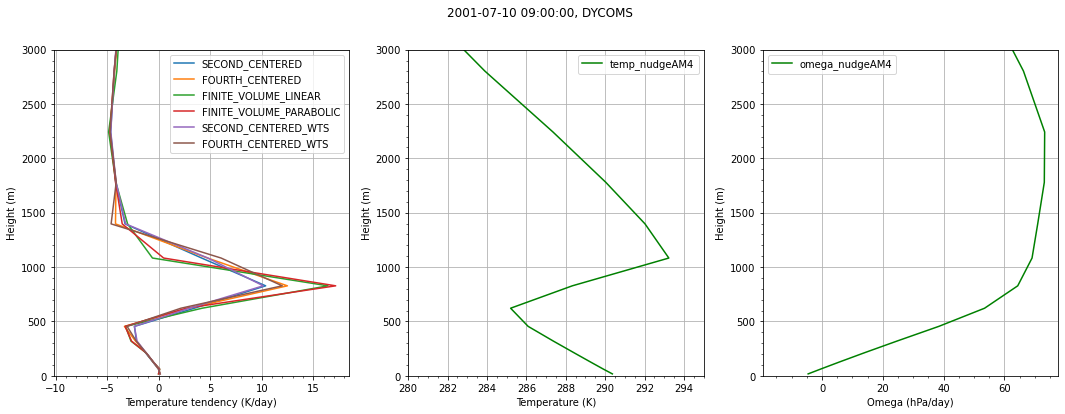

In [66]:
dT_vadv_schemes_ijavg = dT_vadv_schemes.mean("loc").transpose("pfull","scheme")
schemes_name = ["SECOND_CENTERED","FOURTH_CENTERED","FINITE_VOLUME_LINEAR","FINITE_VOLUME_PARABOLIC","SECOND_CENTERED_WTS","FOURTH_CENTERED_WTS"]


#dqv_vadv_schemes_ijavg = dqv_vadv_schemes.mean("loc")

zmin = 0.
zmax = 3000.

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18, 6))

fig.suptitle(time_step+", "+region)

#--- subplot 1: tdt
ax1.plot(dT_vadv_schemes_ijavg*86400., zfull)

ax1.legend(schemes_name)


ax1.grid(True)
ax1.set_ylim([zmin, zmax])
#ax1.legend(["tdt_dyn","tdt_nudge","tdt_hort_adv","tdt_vert_adv","tdt_lw","tdt_scm_1xDiv","tdt_scm_2xDiv"])
ax1.set_xlabel("Temperature tendency (K/day)")
ax1.set_ylabel("Height (m)")

#ax1.set_xlim([-15., 15.])
ax1.minorticks_on()

#--- subplot 2: temperature
ax2.plot(pt_ijavg, zfull, 'g',
         #scm_1xdiv.temp[0,:,0,0], scm_1xdiv.zfull[0,:,0,0], 'k-',
        )
ax2.grid(True)

ax2.set_ylim([zmin, zmax])
ax2.set_xlim([280., 295.])

ax2.legend(["temp_nudgeAM4","temp_scm"])
ax2.set_xlabel("Temperature (K)")
ax2.set_ylabel("Height (m)")

ax2.minorticks_on()

#--- subplot 3: omega
ax3.plot(omega_ijavg*864., zfull, 'g', 
         #scm_1xdiv.omega[0,:,0,0]*864., scm_1xdiv.zfull[0,:,0,0], 'k-',
         #scm_2xdiv.omega[0,:,0,0]*864., scm_2xdiv.zfull[0,:,0,0], 'k:',
        )
ax3.grid(True)

ax3.set_ylim([zmin, zmax])
#ax3.set_xlim([280., 295.])

ax3.legend(["omega_nudgeAM4","omega_scm_1xDiv","omega_scm_2xDiv"])
ax3.set_xlabel("Omega (hPa/day)")
ax3.set_ylabel("Height (m)")

ax3.minorticks_on()

## plot - qdt schemes

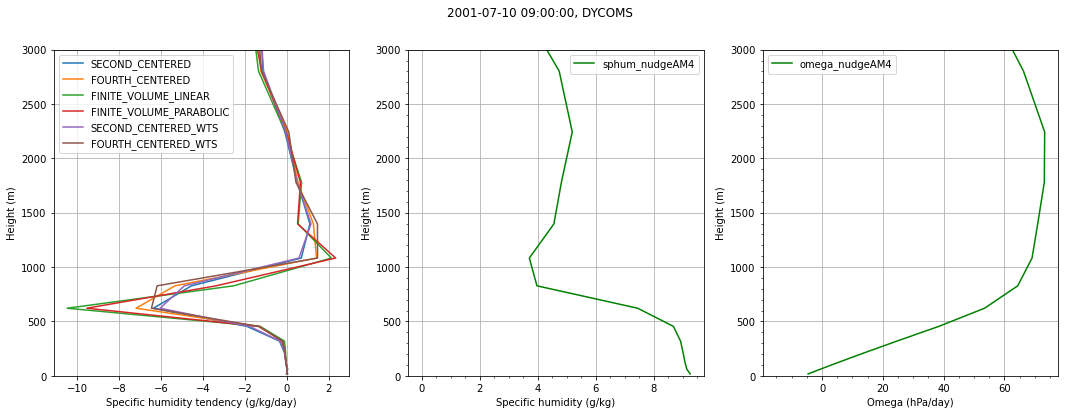

In [70]:
dqv_vadv_schemes_ijavg = dqv_vadv_schemes.mean("loc").transpose("pfull","scheme")
schemes_name = ["SECOND_CENTERED","FOURTH_CENTERED","FINITE_VOLUME_LINEAR","FINITE_VOLUME_PARABOLIC","SECOND_CENTERED_WTS","FOURTH_CENTERED_WTS"]

zmin = 0.
zmax = 3000.

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18, 6))

fig.suptitle(time_step+", "+region)

#--- subplot 1: tdt
ax1.plot(dqv_vadv_schemes_ijavg*86400.*1000., zfull)

ax1.legend(schemes_name)


ax1.grid(True)
ax1.set_ylim([zmin, zmax])
#ax1.legend(["tdt_dyn","tdt_nudge","tdt_hort_adv","tdt_vert_adv","tdt_lw","tdt_scm_1xDiv","tdt_scm_2xDiv"])
ax1.set_xlabel("Specific humidity tendency (g/kg/day)")
ax1.set_ylabel("Height (m)")

#--- subplot 2: temperature
ax2.plot(qq_ijavg*1000., zfull, 'g',
         #scm_1xdiv.sphum[0,:,0,0]*1000., scm_1xdiv.zfull[0,:,0,0], 'k',
        )
ax2.grid(True)

ax2.set_ylim([zmin, zmax])
#ax2.set_xlim([280., 295.])

ax2.legend(["sphum_nudgeAM4","sphum_scm"])
ax2.set_xlabel("Specific humidity (g/kg)")
ax2.set_ylabel("Height (m)")
ax2.minorticks_on()

#--- subplot 3: omega
ax3.plot(omega_ijavg*864., zfull, 'g', 
         #scm_1xdiv.omega[0,:,0,0]*864., scm_1xdiv.zfull[0,:,0,0], 'k',
         #scm_2xdiv.omega[0,:,0,0]*864., scm_2xdiv.zfull[0,:,0,0], 'k:',
        )
ax3.grid(True)

ax3.set_ylim([zmin, zmax])
#ax3.set_xlim([280., 295.])

ax3.legend(["omega_nudgeAM4","omega_scm_1xDiv","omega_scm_2xDiv"])
ax3.set_xlabel("Omega (hPa/day)")
ax3.set_ylabel("Height (m)")
ax3.minorticks_on()

## plott - tdt

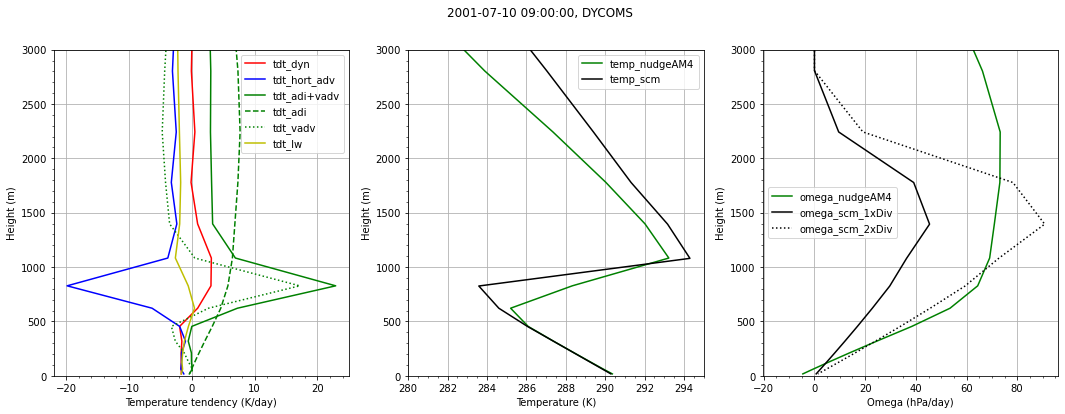

In [82]:
zmin = 0.
zmax = 3000.

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18, 6))

fig.suptitle(time_step+", "+region)

#opt_ax1 = "tdt_all"
opt_ax1 = "tdt_dyn"

if (opt_ax1 == "tdt_all"): 
    #--- subplot 1: temp tendencies
    ax1.plot(tdt_dyn_ijavg*86400., zfull, 'r-',
             tdt_nudge_ijavg*86400., zfull, 'r:',
             tdt_hadv_ijavg*86400., zfull,'b-',
             tdt_vadv_ijavg*86400., zfull,'g-',
             tdt_lw_ijavg*86400., zfull,'y-',
             scm_1xdiv.tdt_vadv[0,:,0,0]*86400., scm_1xdiv.zfull[0,:,0,0], 'k',
             scm_2xdiv.tdt_vadv[0,:,0,0]*86400., scm_2xdiv.zfull[0,:,0,0], 'k:',
             #tdt_adi_ijavg*86400., zfull,'g:',
        )
    ax1.legend(["tdt_dyn","tdt_nudge","tdt_hort_adv","tdt_vert_adv","tdt_lw","tdt_scm_1xDiv","tdt_scm_2xDiv"])

elif (opt_ax1 == "tdt_dyn"):
    ax1.plot(tdt_dyn_ijavg*86400., zfull, 'r-',
             tdt_hadv_ijavg*86400., zfull,'b-',
             tdt_vadv_ijavg*86400., zfull,'g-',
             tdt_adi_ijavg*86400., zfull,'g--',
             dT_vadv_ijavg*86400., zfull,'g:',
             tdt_lw_ijavg*86400., zfull,'y-',
        )
    ax1.legend(["tdt_dyn","tdt_hort_adv","tdt_adi+vadv","tdt_adi","tdt_vadv","tdt_lw"])
    #ax1.set_xlim([-10., 10.])

    
ax1.grid(True)
ax1.set_ylim([zmin, zmax])
#ax1.legend(["tdt_dyn","tdt_nudge","tdt_hort_adv","tdt_vert_adv","tdt_lw","tdt_scm_1xDiv","tdt_scm_2xDiv"])
ax1.set_xlabel("Temperature tendency (K/day)")
ax1.set_ylabel("Height (m)")

#ax1.set_xlim([-15., 15.])
ax1.minorticks_on()

#--- subplot 2: temperature
ax2.plot(pt_ijavg, zfull, 'g',
         scm_1xdiv.temp[0,:,0,0], scm_1xdiv.zfull[0,:,0,0], 'k-',
        )
ax2.grid(True)

ax2.set_ylim([zmin, zmax])
ax2.set_xlim([280., 295.])

ax2.legend(["temp_nudgeAM4","temp_scm"])
ax2.set_xlabel("Temperature (K)")
ax2.set_ylabel("Height (m)")

ax2.minorticks_on()

#--- subplot 3: omega
ax3.plot(omega_ijavg*864., zfull, 'g', 
         scm_1xdiv.omega[0,:,0,0]*864., scm_1xdiv.zfull[0,:,0,0], 'k-',
         scm_2xdiv.omega[0,:,0,0]*864., scm_2xdiv.zfull[0,:,0,0], 'k:',
        )
ax3.grid(True)

ax3.set_ylim([zmin, zmax])
#ax3.set_xlim([280., 295.])

ax3.legend(["omega_nudgeAM4","omega_scm_1xDiv","omega_scm_2xDiv"])
ax3.set_xlabel("Omega (hPa/day)")
ax3.set_ylabel("Height (m)")

ax3.minorticks_on()



## Plot - qdt

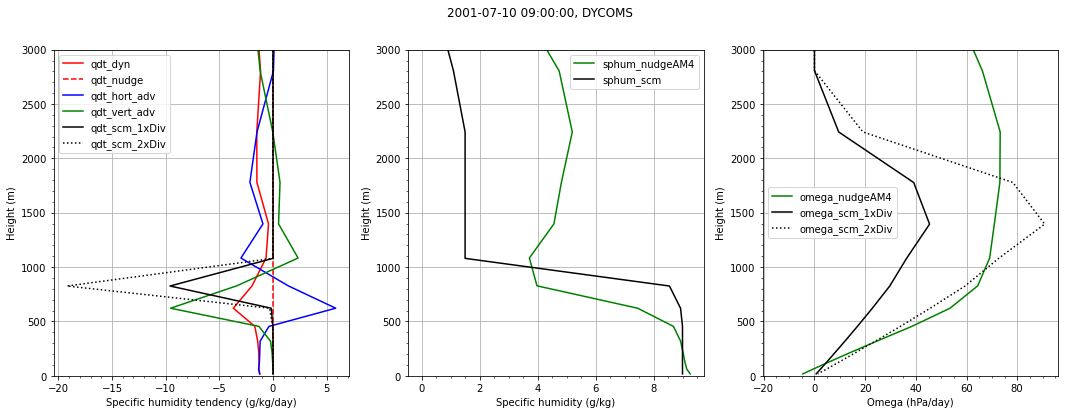

In [81]:
zmin = 0.
zmax = 3000.

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18, 6))

fig.suptitle(time_step+", "+region)

#--- subplot 1: temp tendencies
ax1.plot(qdt_dyn_ijavg*86400.*1000., zfull, 'r',
         qdt_nudge_ijavg*86400.*1000., zfull, 'r--',
         qdt_hadv_ijavg*86400.*1000., zfull,'b-',
         qdt_vadv_ijavg*86400.*1000., zfull,'g-',
         scm_1xdiv.qvdt_vadv[0,:,0,0]*86400.*1000., scm_1xdiv.zfull[0,:,0,0], 'k',
         scm_2xdiv.qvdt_vadv[0,:,0,0]*86400.*1000., scm_2xdiv.zfull[0,:,0,0], 'k:'
        )
ax1.grid(True)
ax1.set_ylim([zmin, zmax])
ax1.legend(["qdt_dyn","qdt_nudge","qdt_hort_adv","qdt_vert_adv","qdt_scm_1xDiv","qdt_scm_2xDiv"])
ax1.set_xlabel("Specific humidity tendency (g/kg/day)")
ax1.set_ylabel("Height (m)")
ax1.minorticks_on()

#--- subplot 2: temperature
ax2.plot(qq_ijavg*1000., zfull, 'g',
         scm_1xdiv.sphum[0,:,0,0]*1000., scm_1xdiv.zfull[0,:,0,0], 'k',
        )
ax2.grid(True)

ax2.set_ylim([zmin, zmax])
#ax2.set_xlim([280., 295.])

ax2.legend(["sphum_nudgeAM4","sphum_scm"])
ax2.set_xlabel("Specific humidity (g/kg)")
ax2.set_ylabel("Height (m)")
ax2.minorticks_on()

#--- subplot 3: omega
ax3.plot(omega_ijavg*864., zfull, 'g', 
         scm_1xdiv.omega[0,:,0,0]*864., scm_1xdiv.zfull[0,:,0,0], 'k',
         scm_2xdiv.omega[0,:,0,0]*864., scm_2xdiv.zfull[0,:,0,0], 'k:',
        )
ax3.grid(True)

ax3.set_ylim([zmin, zmax])
#ax3.set_xlim([280., 295.])

ax3.legend(["omega_nudgeAM4","omega_scm_1xDiv","omega_scm_2xDiv"])
ax3.set_xlabel("Omega (hPa/day)")
ax3.set_ylabel("Height (m)")
ax3.minorticks_on()

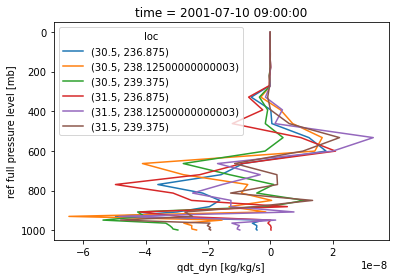

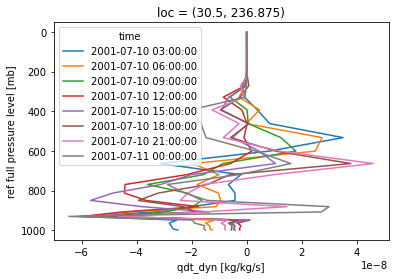

In [9]:
#--- quick plot
time_step = "2001-07-10 07:30:00"
var_region = data.qdt_dyn.sel(lat=lat_slice, lon=lon_slice).stack(loc=("lat","lon"))

tt = 2
var = var_region[tt, :,:]
#print(var)

var.plot.line(y="pfull", yincrease=False)
plt.show()

nn=0
var_tp = var_region[:,:,nn]
var_tp.plot.line(y="pfull", yincrease=False)
plt.show()